In [2]:
# Imports y configuración de paths
import os, sys, numpy as np, pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

PROJ_ROOT = os.path.abspath(os.path.join(os.getcwd(), '..', '..'))
DATA_PATH = os.path.join(PROJ_ROOT, 'data', 'processed', 'mortalidad')
BASE_OUT = os.path.join(PROJ_ROOT, 'modelos', 'outputs')
NOTEBOOK_NAME = os.path.splitext(os.path.basename(os.environ.get('NOTEBOOK_BASENAME', 'b_08_ml.ipynb')))[0]
OUT_DIR = os.path.join(BASE_OUT, 'output', NOTEBOOK_NAME)
os.makedirs(OUT_DIR, exist_ok=True)

print(f'Datos: {DATA_PATH}')
print(f'Salidas: {OUT_DIR}')

pd.set_option('display.width', 140)
pd.set_option('display.max_columns', 60)
sns.set_context('talk')
plt.rcParams['figure.figsize'] = (10,5)

Datos: /Users/scuartasr/Documents/Maestría/Tesis/tfm_tuberc/data/processed/mortalidad
Salidas: /Users/scuartasr/Documents/Maestría/Tesis/tfm_tuberc/modelos/outputs/output/b_08_ml


In [3]:
# Instalar/Importar TensorFlow si es necesario
try:
    import tensorflow as tf
    from tensorflow.keras import layers, models, callbacks, optimizers
    print('TensorFlow:', tf.__version__)
except Exception as e:
    import subprocess, sys as _sys
    print('Instalando TensorFlow ...')
    subprocess.check_call([_sys.executable, '-m', 'pip', 'install', '-q', 'tensorflow'])
    import tensorflow as tf
    from tensorflow.keras import layers, models, callbacks, optimizers
    print('TensorFlow:', tf.__version__)

TensorFlow: 2.17.0


In [4]:
# Estilo corporativo (viz.style)
for candidate in ('src', '../src', '../../src', '../../../src'):
    p = os.path.abspath(candidate)
    if os.path.isdir(p) and p not in sys.path:
        sys.path.append(p)
try:
    import importlib, viz.style as _vstyle
    importlib.reload(_vstyle)
except Exception:
    pass
from viz.style import apply_matplotlib_style, get_palette, get_sequential_cmap
apply_matplotlib_style(n_colors=7, base_font_size=11, seaborn_style='white', background='white', transparent=False)
print('Estilo aplicado.')

Estilo aplicado.


In [5]:
# Carga de datos y matriz edad×año (m y log(m))
EPS = 1e-12
file_long = os.path.join(DATA_PATH, 'tasas_mortalidad_gret_per.csv')
df_long = pd.read_csv(file_long).rename(columns={'ano':'year','gr_et':'age'})
df_long_m = df_long[['year','age','tasa_x100k']].copy()
df_long_m['m'] = (df_long_m['tasa_x100k'] / 1e5).clip(lower=EPS)
mat = df_long_m.pivot(index='age', columns='year', values='m').sort_index()
ages = mat.index.values.astype(int)
years = mat.columns.values.astype(int)
mat_log = np.log(mat.clip(lower=EPS))
print('Matriz m:', mat.shape, '| años', years.min(), '-', years.max(), '| edades', ages.min(), '-', ages.max())
mat.head()

Matriz m: (17, 45) | años 1979 - 2023 | edades 1 - 17


year,1979,1980,1981,1982,1983,1984,1985,1986,1987,1988,1989,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023
age,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,0.000049,0.000042,0.000044,0.000039,0.000028,0.000022,0.000024,0.000018,0.000015,0.000014,0.000011,0.000010,0.000009,0.000009,0.000008,0.000006,0.000006,0.000005,0.000004,0.000006,0.000006,0.000006,0.000005,8.499482e-06,0.000007,6.534167e-06,0.000006,7.710106e-06,0.000005,8.390200e-06,0.000006,0.000003,3.653421e-06,3.153650e-06,5.815563e-06,2.921598e-06,2.398540e-06,2.666065e-06,2.392366e-06,3.153282e-06,3.668709e-06,0.000002,3.129253e-06,4.469724e-06,0.000003
2,0.000012,0.000011,0.000013,0.000010,0.000006,0.000009,0.000009,0.000007,0.000007,0.000005,0.000003,0.000004,0.000004,0.000002,0.000004,0.000003,0.000002,0.000002,0.000002,0.000002,0.000001,0.000002,0.000003,2.798329e-06,0.000002,7.009429e-07,0.000003,1.657103e-06,0.000002,1.449898e-06,0.000002,0.000002,1.249956e-06,2.527166e-07,5.106775e-07,7.732517e-07,1.559143e-06,5.224731e-07,2.617115e-07,4.921904e-07,7.389123e-07,0.000001,4.932269e-07,2.482730e-07,0.000002
3,0.000009,0.000006,0.000010,0.000009,0.000006,0.000007,0.000004,0.000005,0.000003,0.000005,0.000002,0.000004,0.000003,0.000002,0.000002,0.000002,0.000002,0.000002,0.000002,0.000002,0.000003,0.000002,0.000003,7.387396e-07,0.000003,9.613654e-07,0.000002,9.458863e-07,0.000002,9.408289e-07,0.000002,0.000002,7.141590e-07,4.802836e-07,4.853084e-07,9.816835e-07,7.445327e-07,1.002307e-06,1.515173e-06,1.401163e-06,1.396822e-06,0.000001,9.338040e-07,1.178135e-06,0.000001
4,0.000015,0.000013,0.000017,0.000014,0.000012,0.000014,0.000015,0.000008,0.000011,0.000011,0.000008,0.000006,0.000008,0.000008,0.000007,0.000007,0.000006,0.000009,0.000005,0.000006,0.000006,0.000006,0.000006,7.621104e-06,0.000005,3.371316e-06,0.000003,4.305802e-06,0.000005,4.929344e-06,0.000003,0.000003,3.584486e-06,2.853929e-06,3.324185e-06,2.852953e-06,2.863328e-06,4.075270e-06,2.891899e-06,3.997186e-06,3.474033e-06,0.000004,4.770033e-06,5.670935e-06,0.000005
5,0.000034,0.000038,0.000032,0.000031,0.000027,0.000026,0.000019,0.000019,0.000023,0.000018,0.000015,0.000014,0.000014,0.000014,0.000013,0.000016,0.000013,0.000012,0.000011,0.000012,0.000012,0.000011,0.000012,1.439396e-05,0.000011,1.262662e-05,0.000008,8.655184e-06,0.000009,1.042390e-05,0.000010,0.000005,7.747502e-06,6.875696e-06,5.778954e-06,8.438986e-06,5.401696e-06,6.803984e-06,5.055585e-06,7.018536e-06,7.070214e-06,0.000007,1.016314e-05,1.279901e-05,0.000011


In [6]:
# Construcción de secuencias y split temporal
T = 10  # ventanas de historial
cut_year = 2018
idx_cut = int(np.where(years == cut_year)[0][0])
# Normalización (solo con train) en escala log
train_logs = mat_log.iloc[:, :idx_cut+1].values.reshape(-1)
mu, sigma = float(np.mean(train_logs)), float(np.std(train_logs) + 1e-8)

# Generar secuencias train para todas las edades
X_list, y_list, meta_age, meta_year = [], [], [], []
for age in ages:
    s = mat_log.loc[age].values
    for t in range(T, idx_cut+1):  # predice años <= 2018
        X_list.append((s[t-T:t] - mu)/sigma)
        y_list.append((s[t] - mu)/sigma)
        meta_age.append(int(age))
        meta_year.append(int(years[t]))
X_train = np.array(X_list, dtype=np.float32)[..., np.newaxis]  # (N,T,1)
y_train = np.array(y_list, dtype=np.float32)[..., np.newaxis]  # (N,1)
print('Secuencias train:', X_train.shape, y_train.shape)

Secuencias train: (510, 10, 1) (510, 1)


In [7]:
# Definición y entrenamiento del modelo CNN (Conv1D)
from tensorflow.keras import layers, models, callbacks, optimizers

model = models.Sequential([
    layers.Input(shape=(T, 1)),
    layers.Conv1D(filters=32, kernel_size=3, activation='relu', padding='causal'),
    layers.Conv1D(filters=32, kernel_size=3, activation='relu', padding='causal'),
    layers.GlobalAveragePooling1D(),
    layers.Dense(16, activation='relu'),
    layers.Dense(1)
])

opt = optimizers.Adam(learning_rate=1e-3)
model.compile(optimizer=opt, loss='mse')

es = callbacks.EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
hist = model.fit(X_train, y_train, validation_split=0.1, epochs=200, batch_size=32, verbose=0, callbacks=[es])

print('Entrenamiento completado. Épocas:', len(hist.history['loss']))

Entrenamiento completado. Épocas: 52


In [8]:
# Predicciones one-step para train (1979–2018)
yhat_train_scaled = model.predict(X_train, verbose=0).reshape(-1)
yhat_train_log = (yhat_train_scaled * sigma) + mu
ytrue_train_log = np.array([mat_log.loc[a, y] for a, y in zip(meta_age, meta_year)])
m_train_pred = np.exp(yhat_train_log)
m_train_obs = np.exp(ytrue_train_log)
train_df = pd.DataFrame({'age': meta_age, 'year': meta_year, 'm_obs': m_train_obs, 'm_pred': m_train_pred})
print('Predicciones train:', train_df.shape)

Predicciones train: (510, 4)


In [9]:
# Predicciones recursivas para validación (2019–2023)
val_years = years[idx_cut+1:]
Xv_meta_age, Xv_meta_year, yhat_val_log = [], [], []
for age in ages:
    s = mat_log.loc[age].values.copy()
    context = s[idx_cut+1-T:idx_cut+1].copy()  # últimos T hasta 2018
    for yy in val_years:
        xin = ((context - mu)/sigma).astype('float32').reshape(1, T, 1)
        y_scaled = float(model.predict(xin, verbose=0).reshape(-1)[0])
        y_log = y_scaled * sigma + mu
        yhat_val_log.append(y_log)
        Xv_meta_age.append(int(age)); Xv_meta_year.append(int(yy))
        context = np.concatenate([context[1:], [y_log]])

m_val_pred = np.exp(np.array(yhat_val_log))
m_val_obs = np.array([mat.loc[a, y] for a, y in zip(Xv_meta_age, Xv_meta_year)])
val_df = pd.DataFrame({'age': Xv_meta_age, 'year': Xv_meta_year, 'm_obs': m_val_obs, 'm_pred': m_val_pred})
print('Predicciones validación:', val_df.shape)

Predicciones validación: (85, 4)


In [10]:
# Métricas (m y log)
from sklearn.metrics import mean_squared_error, mean_absolute_error

def smape(y_true, y_pred, eps=1e-12):
    return 100 * np.mean(2*np.abs(y_pred - y_true) / (np.abs(y_pred) + np.abs(y_true) + eps))

def wape(y_true, y_pred, eps=1e-12):
    return 100 * (np.sum(np.abs(y_pred - y_true)) / (np.sum(np.abs(y_true)) + eps))

# Train
RMSE_train = float(np.sqrt(mean_squared_error(train_df['m_obs'], train_df['m_pred'])))
MAE_train = float(mean_absolute_error(train_df['m_obs'], train_df['m_pred']))
sMAPE_train = float(smape(train_df['m_obs'], train_df['m_pred']))
WAPE_train = float(wape(train_df['m_obs'], train_df['m_pred']))
RMSE_log_train = float(np.sqrt(mean_squared_error(np.log(train_df['m_obs'].clip(lower=EPS)), yhat_train_log)))

# Val
RMSE_val = float(np.sqrt(mean_squared_error(val_df['m_obs'], val_df['m_pred'])))
MAE_val = float(mean_absolute_error(val_df['m_obs'], val_df['m_pred']))
sMAPE_val = float(smape(val_df['m_obs'], val_df['m_pred']))
WAPE_val = float(wape(val_df['m_obs'], val_df['m_pred']))
RMSE_log_val = float(np.sqrt(mean_squared_error(np.log(val_df['m_obs'].clip(lower=EPS)), np.array(yhat_val_log))))

print('Métricas (escala original por persona):')
print(f'- Train | RMSE: {RMSE_train:.4e} | MAE: {MAE_train:.4e} | sMAPE: {sMAPE_train:.2f}% | WAPE: {WAPE_train:.2f}%')
print(f'- Val   | RMSE: {RMSE_val:.4e} | MAE: {MAE_val:.4e} | sMAPE: {sMAPE_val:.2f}% | WAPE: {WAPE_val:.2f}%')
print('Métricas (escala log):')
print(f'- Train | RMSE_log: {RMSE_log_train:.4e}')
print(f'- Val   | RMSE_log: {RMSE_log_val:.4e}')

Métricas (escala original por persona):
- Train | RMSE: 2.0841e-05 | MAE: 1.0623e-05 | sMAPE: 19.81% | WAPE: 15.09%
- Val   | RMSE: 1.5039e-05 | MAE: 9.6321e-06 | sMAPE: 40.14% | WAPE: 22.63%
Métricas (escala log):
- Train | RMSE_log: 2.7599e-01
- Val   | RMSE_log: 4.9797e-01


dtype pred full: [dtype('float64')]


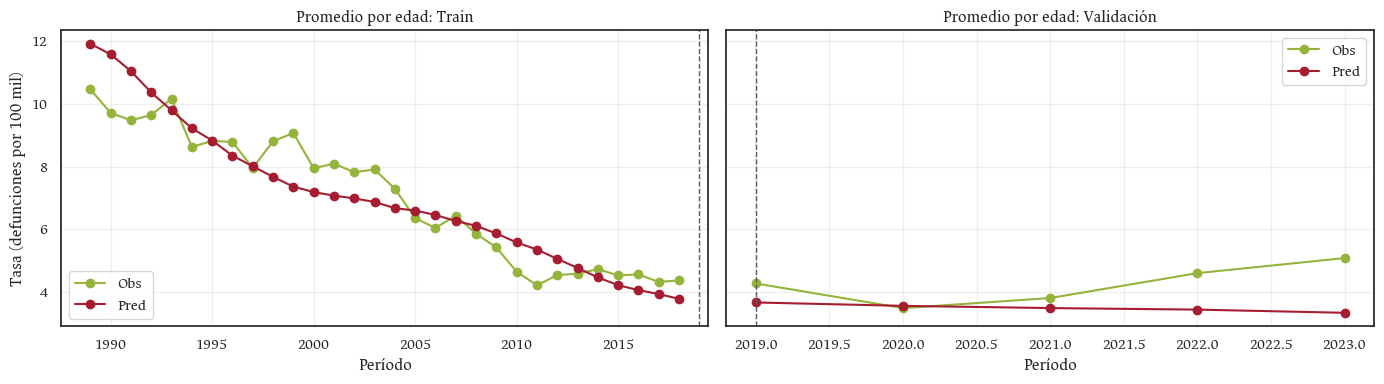

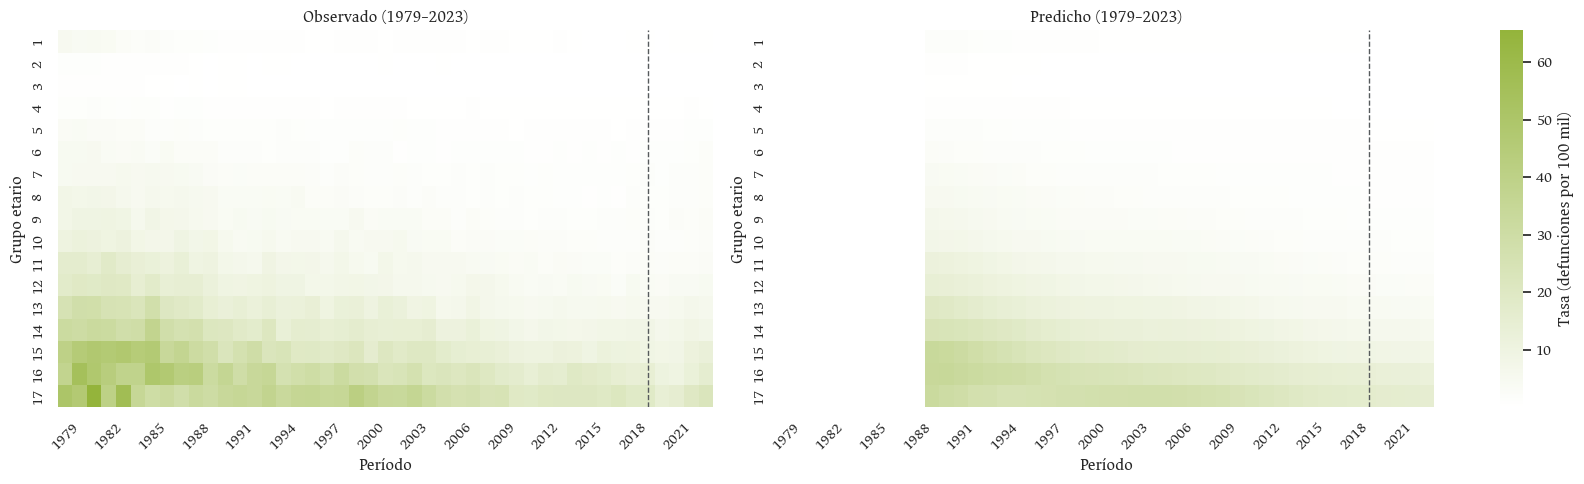

In [11]:
# Reconstrucción matrices y gráficos principales
from viz.style import get_palette, get_sequential_cmap
pal = get_palette(5)
color_obs, color_pred, color_vline = pal[0], pal[1], pal[4]

# Matrices predichas (m)
mat_train_pred = pd.pivot_table(train_df, index='age', columns='year', values='m_pred').reindex(index=ages, columns=years, fill_value=np.nan)
mat_val_pred = pd.pivot_table(val_df, index='age', columns='year', values='m_pred').reindex(index=ages, columns=years, fill_value=np.nan)
mat_obs_100k = mat * 1e5
mat_train_pred_100k = mat_train_pred * 1e5
mat_val_pred_100k = mat_val_pred * 1e5

# Averages por período
df_period_train = train_df.groupby('year')[['m_obs','m_pred']].mean().reset_index().rename(columns={'year':'period','m_obs':'obs','m_pred':'pred'})
df_period_val = val_df.groupby('year')[['m_obs','m_pred']].mean().reset_index().rename(columns={'year':'period','m_obs':'obs','m_pred':'pred'})

# Matriz completa predicha (100k) asegurando dtype float
mat_pred_full_100k = pd.DataFrame(np.nan, index=ages, columns=years, dtype=float)
train_periods = df_period_train['period'].values.astype(int)
val_periods = df_period_val['period'].values.astype(int)
mat_pred_full_100k.loc[:, train_periods] = mat_train_pred_100k.loc[:, train_periods].values.astype(float)
mat_pred_full_100k.loc[:, val_periods] = mat_val_pred_100k.loc[:, val_periods].values.astype(float)
print('dtype pred full:', mat_pred_full_100k.dtypes.unique())

# Líneas promedio por período (100k)
fig, ax = plt.subplots(1,2, figsize=(14,4), sharey=True)
ax[0].plot(df_period_train['period'], df_period_train['obs']*1e5, label='Obs', marker='o', color=color_obs)
ax[0].plot(df_period_train['period'], df_period_train['pred']*1e5, label='Pred', marker='o', color=color_pred)
ax[0].set_title('Promedio por edad: Train'); ax[0].set_xlabel('Período'); ax[0].set_ylabel('Tasa (defunciones por 100 mil)'); ax[0].grid(alpha=0.3); ax[0].legend(); ax[0].axvline(2019, color=color_vline, ls='--', lw=1)
ax[1].plot(df_period_val['period'], df_period_val['obs']*1e5, label='Obs', marker='o', color=color_obs)
ax[1].plot(df_period_val['period'], df_period_val['pred']*1e5, label='Pred', marker='o', color=color_pred)
ax[1].set_title('Promedio por edad: Validación'); ax[1].set_xlabel('Período'); ax[1].grid(alpha=0.3); ax[1].legend(); ax[1].axvline(2019, color=color_vline, ls='--', lw=1)
plt.tight_layout(); plt.savefig(os.path.join(OUT_DIR,'cnn_lineas_obs_vs_pred_100k.png'), dpi=180); plt.show()

# Heatmaps Obs vs Pred
vmin = float(min(mat_obs_100k.values.min(), mat_pred_full_100k.values.min()))
vmax = float(max(mat_obs_100k.values.max(), mat_pred_full_100k.values.max()))
cmap_seq = get_sequential_cmap(index=0)
ages_sorted = np.sort(ages)
if ages_sorted.min() == 0:
    age_labels = [f'{a*5}-{a*5+4}' if a < 16 else '80+' for a in ages_sorted]
else:
    age_labels = [f'{(a-1)*5}-{(a-1)*5+4}' if a < 17 else '80+' for a in ages_sorted]

fig = plt.figure(figsize=(16,5))
gs = fig.add_gridspec(1,3, width_ratios=[1,1,0.035])
ax0 = fig.add_subplot(gs[0,0]); ax1 = fig.add_subplot(gs[0,1], sharey=ax0); cax = fig.add_subplot(gs[0,2])
sns.heatmap(mat_obs_100k, ax=ax0, cmap=cmap_seq, vmin=vmin, vmax=vmax, cbar=False)
ax0.set_title('Observado (1979–2023)'); ax0.set_xlabel('Período'); ax0.set_ylabel('Grupo etario')
sns.heatmap(mat_pred_full_100k, ax=ax1, cmap=cmap_seq, vmin=vmin, vmax=vmax, cbar=True, cbar_ax=cax)
ax1.set_title('Predicho (1979–2023)'); ax1.set_xlabel('Período'); ax1.set_ylabel('Grupo etario')

tick_years = np.arange(1979, 2022, 3)
period_list = list(years)
pos_ticks = [period_list.index(y)+0.5 for y in tick_years if y in period_list]
lab_ticks = [str(y) for y in tick_years if y in period_list]
for a in (ax0, ax1):
    a.set_xticks(pos_ticks); a.set_xticklabels(lab_ticks, rotation=45)
idx_2019 = np.where(years == 2019)[0]
if len(idx_2019):
    xline = idx_2019[0]+0.5
    ax0.axvline(xline, color=color_vline, ls='--', lw=1)
    ax1.axvline(xline, color=color_vline, ls='--', lw=1)

cax.set_ylabel('Tasa (defunciones por 100 mil)')
plt.tight_layout(); plt.savefig(os.path.join(OUT_DIR,'cnn_matrices_obs_pred_1979_2023_100k.png'), dpi=180); plt.show()

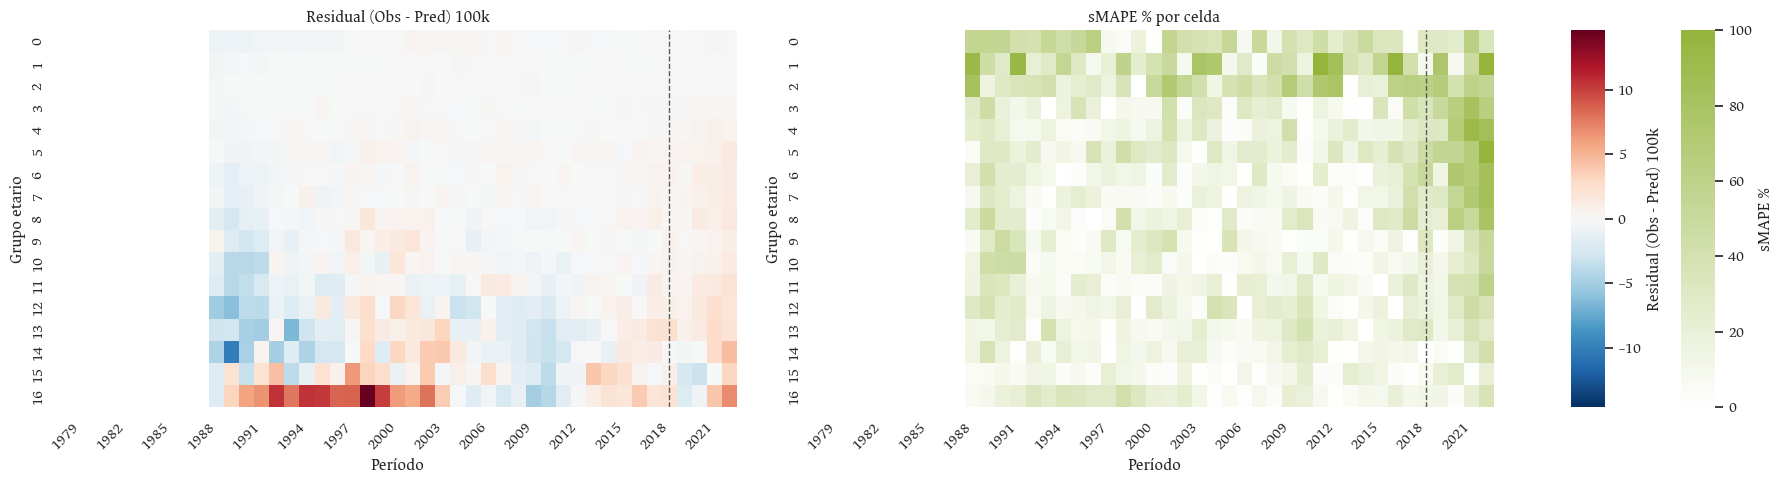

In [12]:
# Heatmaps residuales y sMAPE por celda
EPS_CELL = 1e-12
resid_100k = mat_obs_100k.values - mat_pred_full_100k.values
smape_cell = (2 * np.abs(mat_pred_full_100k.values - mat_obs_100k.values) / (np.abs(mat_pred_full_100k.values) + np.abs(mat_obs_100k.values) + EPS_CELL))*100
vmax_res = np.nanmax(np.abs(resid_100k)); vmin_res = -vmax_res
vmin_sm, vmax_sm = 0, min(100, np.nanmax(smape_cell))

cmap_seq = get_sequential_cmap(index=0)
fig = plt.figure(figsize=(18,5))
gs = fig.add_gridspec(1,4, width_ratios=[1,1,0.05,0.05])
ax_r = fig.add_subplot(gs[0,0]); ax_s = fig.add_subplot(gs[0,1], sharey=ax_r); cax_r = fig.add_subplot(gs[0,2]); cax_s = fig.add_subplot(gs[0,3])

sns.heatmap(resid_100k, ax=ax_r, cmap='RdBu_r', vmin=vmin_res, vmax=vmax_res, cbar=True, cbar_ax=cax_r)
ax_r.set_title('Residual (Obs - Pred) 100k'); ax_r.set_xlabel('Período'); ax_r.set_ylabel('Grupo etario')

sns.heatmap(smape_cell, ax=ax_s, cmap=cmap_seq, vmin=vmin_sm, vmax=vmax_sm, cbar=True, cbar_ax=cax_s)
ax_s.set_title('sMAPE % por celda'); ax_s.set_xlabel('Período'); ax_s.set_ylabel('Grupo etario')

tick_years = np.arange(1979, 2022, 3); period_list = list(years)
pos_ticks = [period_list.index(y)+0.5 for y in tick_years if y in period_list]
lab_ticks = [str(y) for y in tick_years if y in period_list]
for a in (ax_r, ax_s):
    a.set_xticks(pos_ticks); a.set_xticklabels(lab_ticks, rotation=45)
idx_2019 = np.where(years == 2019)[0]
if len(idx_2019):
    xline = idx_2019[0]+0.5
    for a in (ax_r, ax_s): a.axvline(xline, color=color_vline, ls='--', lw=1)

cax_r.set_ylabel('Residual (Obs - Pred) 100k')
cax_s.set_ylabel('sMAPE %')
plt.tight_layout(); plt.savefig(os.path.join(OUT_DIR,'cnn_heatmaps_residual_smape_100k.png'), dpi=180); plt.show()

In [13]:
# Exportar matrices y formato long
mat_pred_full_m = mat_pred_full_100k / 1e5
mat_pred_full_m.index.name = 'gr_et'
mat_pred_full_100k.index.name = 'gr_et'
mat_pred_full_m.reset_index().to_csv(os.path.join(OUT_DIR,'cnn_matriz_pred_m.csv'), index=False)
mat_pred_full_100k.reset_index().to_csv(os.path.join(OUT_DIR,'cnn_matriz_pred_tasa_x100k.csv'), index=False)

# Formato long con errores (100k)
EPS_ERR = 1e-12
train_long = train_df.copy(); val_long = val_df.copy()
for d in (train_long, val_long):
    d['obs_tasa_x100k'] = d['m_obs'] * 1e5
    d['pred_tasa_x100k'] = d['m_pred'] * 1e5
    d['abs_error_100k'] = (d['pred_tasa_x100k'] - d['obs_tasa_x100k']).abs()
    d['rel_abs_error'] = d['abs_error_100k'] / (d['obs_tasa_x100k'].abs() + EPS_ERR)
train_long['dataset'] = 'train'; val_long['dataset'] = 'valid'
cols_out = ['dataset','year','age','obs_tasa_x100k','pred_tasa_x100k','abs_error_100k','rel_abs_error']
pred_long = pd.concat([train_long[cols_out], val_long[cols_out]], ignore_index=True).sort_values(['dataset','year','age']).reset_index(drop=True)
long_path = os.path.join(OUT_DIR,'cnn_predicciones_long_100k.csv')
pred_long.to_csv(long_path, index=False)
print('Exportaciones guardadas en:', OUT_DIR)
print('Long shape:', pred_long.shape)
pred_long.head()

Exportaciones guardadas en: /Users/scuartasr/Documents/Maestría/Tesis/tfm_tuberc/modelos/outputs/output/b_08_ml
Long shape: (595, 7)


,dataset,year,age,obs_tasa_x100k,pred_tasa_x100k,abs_error_100k,rel_abs_error
0,train,1989,1,1.143999,2.032883,0.888884,0.776998
1,train,1989,2,0.261641,0.716484,0.454843,1.738424
2,train,1989,3,0.202635,0.487863,0.285229,1.407603
3,train,1989,4,0.764219,1.015334,0.251116,0.328592
4,train,1989,5,1.505478,1.926173,0.420695,0.279443


# Sección: Búsqueda en grilla de hiperparámetros
## Objetivo
Realizar el mismo ajuste del modelo variando hiperparámetros y seleccionar el mejor según métrica de validación.

In [16]:
# Búsqueda en grilla usando la misma CNN y validación recursiva
import itertools
import numpy as np
import pandas as pd
from copy import deepcopy
from tensorflow.keras import layers, models, callbacks, optimizers

# Grilla de hiperparámetros
param_grid = {
    "conv_layers": [2, 3],            
    "filters": [16, 32, 64],          
    "kernel_size": [3, 5],            
    "dense_units": [16, 32],          
    "learning_rate": [1e-3, 5e-4],    
    "batch_size": [32, 64],           
    "epochs": [150, 250],             
    "spatial_dropout": [0.0, 0.1, 0.2],
    "dense_dropout": [0.0, 0.3, 0.5]
}

es_cb = callbacks.EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)


def build_cnn(conv_layers=2, filters=32, kernel_size=3, dense_units=16, learning_rate=1e-3,
    spatial_dropout=0.0, dense_dropout=0.0):
    model = models.Sequential()
    model.add(layers.Input(shape=(T, 1)))
    for _ in range(conv_layers):
        model.add(
            layers.Conv1D(
                filters=filters,
                kernel_size=kernel_size,
                activation='relu',
                padding='causal'))
        if spatial_dropout > 0.0:
            model.add(layers.SpatialDropout1D(spatial_dropout))
    model.add(layers.GlobalAveragePooling1D())
    model.add(layers.Dense(dense_units, activation='relu'))
    if dense_dropout > 0.0:
        model.add(layers.Dropout(dense_dropout))
    model.add(layers.Dense(1))
    opt = optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=opt, loss='mse')
    return model


def compute_metrics(y_true, y_pred):
    eps = EPS if 'EPS' in globals() else 1e-12
    rmse = float(np.sqrt(np.mean((y_true - y_pred) ** 2)))
    mae = float(np.mean(np.abs(y_true - y_pred)))
    wape = float(100 * (np.sum(np.abs(y_pred - y_true)) / (np.sum(np.abs(y_true)) + eps)))
    smape = float(100 * np.mean(2.0 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred) + eps)))
    mape = float(100 * np.mean(np.abs((y_true - y_pred) / (y_true + eps))))
    return {"RMSE": rmse, "MAE": mae, "WAPE": wape, "sMAPE": smape, "MAPE": mape, "MSE": rmse**2}


def predict_recursive(model):
    # Reproduce la lógica de la celda de validación (2019–2023)
    val_years_local = years[idx_cut+1:]
    Xv_meta_age_local, Xv_meta_year_local, yhat_val_log_local = [], [], []
    for age in ages:
        s = mat_log.loc[age].values.copy()
        context = s[idx_cut+1-T:idx_cut+1].copy()
        for yy in val_years_local:
            xin = ((context - mu)/sigma).astype('float32').reshape(1, T, 1)
            y_scaled = float(model.predict(xin, verbose=0).reshape(-1)[0])
            y_log = y_scaled * sigma + mu
            yhat_val_log_local.append(y_log)
            Xv_meta_age_local.append(int(age)); Xv_meta_year_local.append(int(yy))
            context = np.concatenate([context[1:], [y_log]])
    m_val_pred_local = np.exp(np.array(yhat_val_log_local))
    m_val_obs_local = np.array([mat.loc[a, y] for a, y in zip(Xv_meta_age_local, Xv_meta_year_local)])
    return m_val_obs_local, m_val_pred_local


results = []
best = {"params": None, "metrics": None, "history": None}

In [18]:
# Ejecutar grilla
for values in itertools.product(*param_grid.values()):
    params = dict(zip(param_grid.keys(), values))
    try:
        spatial_dropout = 0.0 if params["filters"] <= 16 else params["spatial_dropout"]
        model_g = build_cnn(
            conv_layers=params["conv_layers"],
            filters=params["filters"],
            kernel_size=params["kernel_size"],
            dense_units=params["dense_units"],
            learning_rate=params["learning_rate"],
            spatial_dropout=spatial_dropout,
            dense_dropout=params["dense_dropout"],
        )
        hist_g = model_g.fit(
            X_train, y_train,
            validation_split=0.1,
            epochs=params["epochs"],
            batch_size=params["batch_size"],
            verbose=0,
            callbacks=[es_cb],
            shuffle=False,
        )
        # Validación recursiva sobre el mismo set que arriba
        m_val_obs_g, m_val_pred_g = predict_recursive(model_g)
        metrics = compute_metrics(m_val_obs_g, m_val_pred_g)
        row = deepcopy(params); row.update(metrics)
        results.append(row)
        if (best["metrics"] is None) or (metrics["sMAPE"] < best["metrics"]["sMAPE"]):
            best["params"] = params
            best["metrics"] = metrics
            best["history"] = hist_g.history
    except Exception as e:
        row = deepcopy(params)
        row.update({"error": str(e)})
        results.append(row)

In [19]:
# Mostrar resultados
df_results = pd.DataFrame(results)
display(df_results.sort_values(['sMAPE','RMSE'], ascending=[True, True]).head(10))
print("Mejor configuración:")
print(best["params"]) 
print("Métricas de validación (mejor):", best["metrics"])

,conv_layers,filters,kernel_size,dense_units,learning_rate,batch_size,epochs,spatial_dropout,dense_dropout,RMSE,MAE,WAPE,sMAPE,MAPE,MSE
664,2,32,3,16,0.001,32,250,0.1,0.0,0.000015,0.000009,22.079000,37.628976,30.956929,2.215051e-10
1543,3,32,3,16,0.001,64,250,0.0,0.0,0.000014,0.000009,21.444238,41.249516,32.894862,1.837716e-10
964,2,64,3,16,0.001,64,150,0.2,0.0,0.000012,0.000008,18.904696,42.113334,120.684972,1.528879e-10
895,2,32,5,32,0.001,64,250,0.0,0.0,0.000013,0.000009,21.256005,43.267277,33.741660,1.809925e-10
1085,2,64,5,16,0.001,32,150,0.0,0.3,0.000044,0.000022,52.669397,45.540593,45.855717,1.967441e-09
1090,2,64,5,16,0.001,32,150,0.2,0.0,0.000047,0.000024,55.891456,46.024301,40.632535,2.201118e-09
297,2,32,3,16,0.001,32,250,0.0,0.0,0.000015,0.000010,23.734706,46.130309,35.513753,2.401260e-10
1101,2,64,5,16,0.001,32,250,0.2,0.5,0.000047,0.000024,55.786998,47.812062,46.138267,2.200182e-09
1163,2,64,5,32,0.001,32,150,0.2,0.3,0.000049,0.000025,59.105371,48.490603,40.502295,2.424627e-09
1159,2,64,5,32,0.001,32,150,0.1,0.0,0.000046,0.000023,54.246987,48.639324,51.753359,2.071665e-09


Mejor configuración:
{'conv_layers': 2, 'filters': 32, 'kernel_size': 3, 'dense_units': 16, 'learning_rate': 0.001, 'batch_size': 32, 'epochs': 250, 'spatial_dropout': 0.1, 'dense_dropout': 0.0}
Métricas de validación (mejor): {'RMSE': 1.4883047557049813e-05, 'MAE': 9.396713372481109e-06, 'WAPE': 22.079000419169617, 'sMAPE': 37.628976155180425, 'MAPE': 30.956929197158335, 'MSE': 2.215051045854064e-10}


In [21]:
# Mejor modelo: reentrenar, predecir y métricas (train y validación)
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras import callbacks

assert 'best' in globals() and best.get('params') is not None, "No se encontraron hiperparámetros 'best'. Ejecuta la celda de grilla primero."

# Reconstruir y entrenar el mejor modelo
best_params = best['params']
best_model = build_cnn(
    conv_layers=best_params['conv_layers'],
    filters=best_params['filters'],
    kernel_size=best_params['kernel_size'],
    dense_units=best_params['dense_units'],
    learning_rate=best_params['learning_rate']
)
es2 = callbacks.EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
hist_best = best_model.fit(
    X_train, y_train,
    validation_split=0.1,
    epochs=best_params['epochs'],
    batch_size=best_params['batch_size'],
    verbose=0,
    callbacks=[es2]
)

# Predicciones one-step para TRAIN con mejor modelo
yhat_train_scaled_best = best_model.predict(X_train, verbose=0).reshape(-1)
yhat_train_log_best = (yhat_train_scaled_best * sigma) + mu
# Verdaderos (log) para TRAIN usando meta_age/meta_year
ytrue_train_log_best = np.array([mat_log.loc[a, y] for a, y in zip(meta_age, meta_year)])
# A escala original (m)
m_train_pred_best = np.exp(yhat_train_log_best)
m_train_obs_best = np.exp(ytrue_train_log_best)

# DataFrame de TRAIN (mejor)
train_df_best = pd.DataFrame({'age': meta_age, 'year': meta_year, 'm_obs': m_train_obs_best, 'm_pred': m_train_pred_best})

# Predicciones recursivas VALIDACIÓN con mejor modelo (2019–2023)
def _predict_recursive_with(model):
    val_years_local = years[idx_cut+1:]
    Xv_meta_age_local, Xv_meta_year_local, yhat_val_log_local = [], [], []
    for age in ages:
        s = mat_log.loc[age].values.copy()
        context = s[idx_cut+1-T:idx_cut+1].copy()
        for yy in val_years_local:
            xin = ((context - mu)/sigma).astype('float32').reshape(1, T, 1)
            y_scaled = float(model.predict(xin, verbose=0).reshape(-1)[0])
            y_log = y_scaled * sigma + mu
            yhat_val_log_local.append(y_log)
            Xv_meta_age_local.append(int(age)); Xv_meta_year_local.append(int(yy))
            context = np.concatenate([context[1:], [y_log]])
    m_val_pred_local = np.exp(np.array(yhat_val_log_local))
    m_val_obs_local = np.array([mat.loc[a, y] for a, y in zip(Xv_meta_age_local, Xv_meta_year_local)])
    return Xv_meta_age_local, Xv_meta_year_local, m_val_obs_local, m_val_pred_local, np.array(yhat_val_log_local)

Xv_age_b, Xv_year_b, m_val_obs_b, m_val_pred_b, yhat_val_log_b = _predict_recursive_with(best_model)
val_df_best = pd.DataFrame({'age': Xv_age_b, 'year': Xv_year_b, 'm_obs': m_val_obs_b, 'm_pred': m_val_pred_b})

# Métricas
EPS_LOCAL = EPS if 'EPS' in globals() else 1e-12

def _smape(y_true, y_pred, eps=1e-12):
    return 100 * np.mean(2*np.abs(y_pred - y_true) / (np.abs(y_pred) + np.abs(y_true) + eps))

def _wape(y_true, y_pred, eps=1e-12):
    return 100 * (np.sum(np.abs(y_pred - y_true)) / (np.sum(np.abs(y_true)) + eps))

# Train (mejor)
RMSE_train_best = float(np.sqrt(mean_squared_error(m_train_obs_best, m_train_pred_best)))
MAE_train_best = float(mean_absolute_error(m_train_obs_best, m_train_pred_best))
sMAPE_train_best = float(_smape(m_train_obs_best, m_train_pred_best))
WAPE_train_best = float(_wape(m_train_obs_best, m_train_pred_best))
RMSE_log_train_best = float(np.sqrt(mean_squared_error(np.log(np.clip(m_train_obs_best, EPS_LOCAL, None)), yhat_train_log_best)))
MSE_train_best = RMSE_train_best**2
MSE_log_train_best = RMSE_log_train_best**2
MAPE_train_best = float(100 * np.mean(np.abs((m_train_obs_best - m_train_pred_best) / (m_train_obs_best + EPS_LOCAL))))


# Val (mejor)
RMSE_val_best = float(np.sqrt(mean_squared_error(val_df_best['m_obs'], val_df_best['m_pred'])))
MAE_val_best = float(mean_absolute_error(val_df_best['m_obs'], val_df_best['m_pred']))
sMAPE_val_best = float(_smape(val_df_best['m_obs'], val_df_best['m_pred']))
WAPE_val_best = float(_wape(val_df_best['m_obs'], val_df_best['m_pred']))
RMSE_log_val_best = float(np.sqrt(mean_squared_error(np.log(np.clip(val_df_best['m_obs'].values, EPS_LOCAL, None)), yhat_val_log_b)))
MSE_val_best = RMSE_val_best**2
MAPE_val_best = float(100 * np.mean(np.abs((val_df_best['m_obs'].values - val_df_best['m_pred'].values) / (val_df_best['m_obs'].values + EPS_LOCAL))))

print('Métricas MEJOR MODELO (escala original por persona):')
print(f'- Train | RMSE: {RMSE_train_best:.4e} | MAE: {MAE_train_best:.4e} | sMAPE: {sMAPE_train_best:.2f}% | WAPE: {WAPE_train_best:.2f}% | MSE: {MSE_train_best:.4e} | MAPE: {MAPE_train_best:.2f}%')
print(f'- Val   | RMSE: {RMSE_val_best:.4e} | MAE: {MAE_val_best:.4e} | sMAPE: {sMAPE_val_best:.2f}% | WAPE: {WAPE_val_best:.2f}% | | MSE: {MSE_val_best:.4e} | MAPE: {MAPE_val_best:.2f}%')
print('Métricas MEJOR MODELO (escala log):')
print(f'- Train | RMSE_log: {RMSE_log_train_best:.4e} | MSE_log: {MSE_log_train_best:.4e}')
print(f'- Val   | RMSE_log: {RMSE_log_val_best:.4e}')

Métricas MEJOR MODELO (escala original por persona):
- Train | RMSE: 2.0038e-05 | MAE: 1.0397e-05 | sMAPE: 19.68% | WAPE: 14.77% | MSE: 4.0150e-10 | MAPE: 21.87%
- Val   | RMSE: 1.4904e-05 | MAE: 9.6684e-06 | sMAPE: 41.57% | WAPE: 22.72% | | MSE: 2.2214e-10 | MAPE: 32.92%
Métricas MEJOR MODELO (escala log):
- Train | RMSE_log: 2.7296e-01 | MSE_log: 7.4509e-02
- Val   | RMSE_log: 5.1926e-01


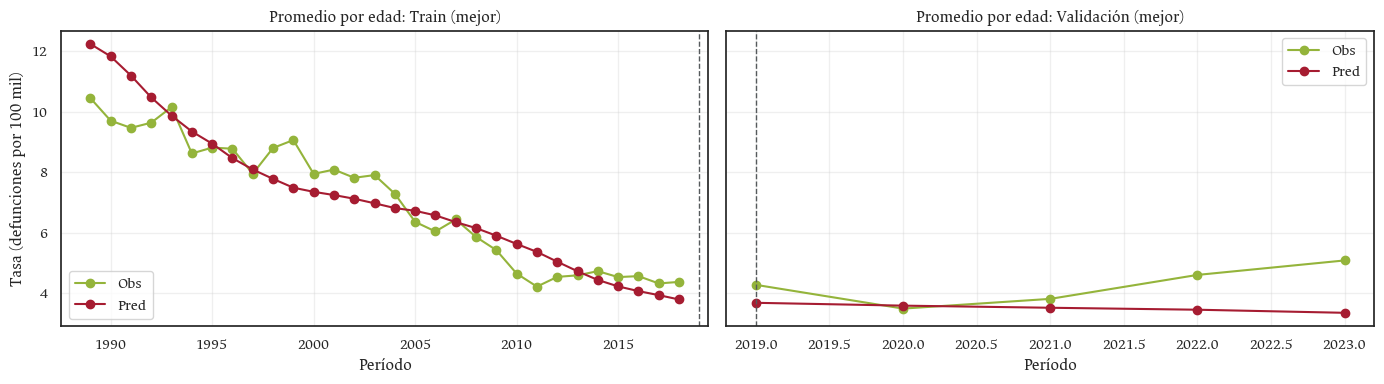

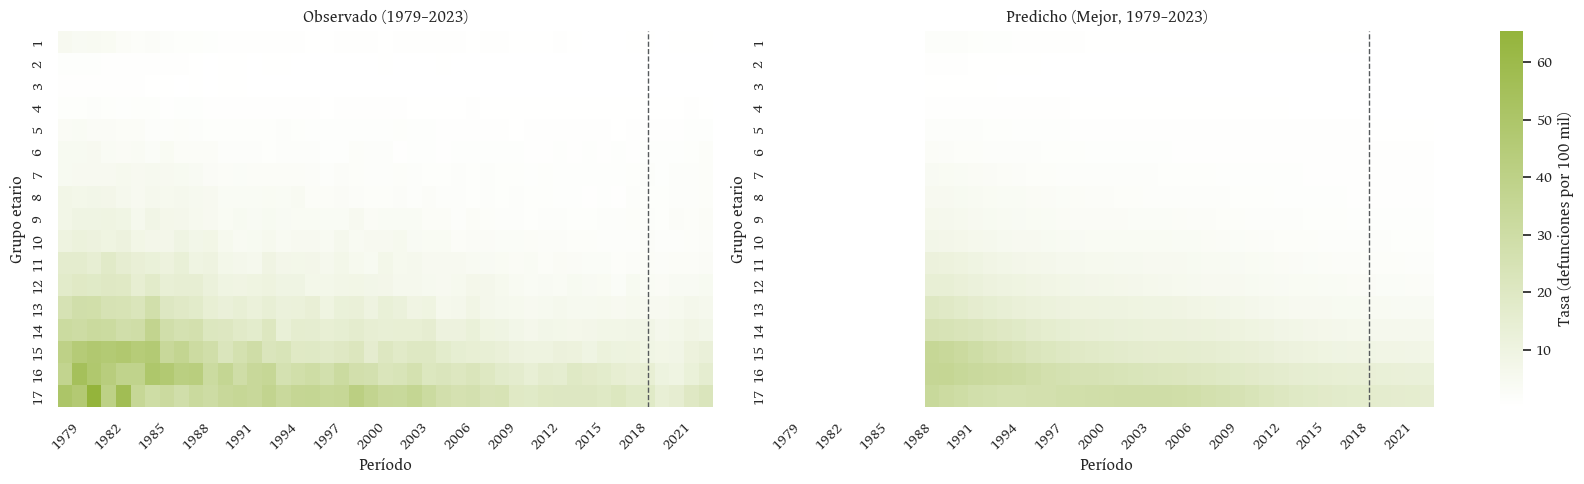

In [22]:
# Mejor modelo: matrices y heatmaps (Obs vs Pred)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from viz.style import get_palette, get_sequential_cmap

# Asegurar disponibilidad de dataframes del mejor modelo
assert 'train_df_best' in globals() and 'val_df_best' in globals(), "Faltan predicciones del mejor modelo. Ejecuta la celda anterior."

pal = get_palette(5)
color_obs, color_pred, color_vline = pal[0], pal[1], pal[4]

# Matrices predichas (m)
mat_train_pred_best = pd.pivot_table(train_df_best, index='age', columns='year', values='m_pred').reindex(index=ages, columns=years, fill_value=np.nan)
mat_val_pred_best = pd.pivot_table(val_df_best, index='age', columns='year', values='m_pred').reindex(index=ages, columns=years, fill_value=np.nan)
mat_obs_100k = mat * 1e5
mat_train_pred_100k_best = mat_train_pred_best * 1e5
mat_val_pred_100k_best = mat_val_pred_best * 1e5

# Averages por período
_df_period_train_b = train_df_best.groupby('year')[['m_obs','m_pred']].mean().reset_index().rename(columns={'year':'period','m_obs':'obs','m_pred':'pred'})
_df_period_val_b = val_df_best.groupby('year')[['m_obs','m_pred']].mean().reset_index().rename(columns={'year':'period','m_obs':'obs','m_pred':'pred'})

# Matriz completa predicha (100k)
mat_pred_full_100k_best = pd.DataFrame(np.nan, index=ages, columns=years, dtype=float)
train_periods_b = _df_period_train_b['period'].values.astype(int)
val_periods_b = _df_period_val_b['period'].values.astype(int)
mat_pred_full_100k_best.loc[:, train_periods_b] = mat_train_pred_100k_best.loc[:, train_periods_b].values.astype(float)
mat_pred_full_100k_best.loc[:, val_periods_b] = mat_val_pred_100k_best.loc[:, val_periods_b].values.astype(float)

# Líneas promedio por período (100k)
fig, ax = plt.subplots(1,2, figsize=(14,4), sharey=True)
ax[0].plot(_df_period_train_b['period'], _df_period_train_b['obs']*1e5, label='Obs', marker='o', color=color_obs)
ax[0].plot(_df_period_train_b['period'], _df_period_train_b['pred']*1e5, label='Pred', marker='o', color=color_pred)
ax[0].set_title('Promedio por edad: Train (mejor)'); ax[0].set_xlabel('Período'); ax[0].set_ylabel('Tasa (defunciones por 100 mil)'); ax[0].grid(alpha=0.3); ax[0].legend(); ax[0].axvline(2019, color=color_vline, ls='--', lw=1)
ax[1].plot(_df_period_val_b['period'], _df_period_val_b['obs']*1e5, label='Obs', marker='o', color=color_obs)
ax[1].plot(_df_period_val_b['period'], _df_period_val_b['pred']*1e5, label='Pred', marker='o', color=color_pred)
ax[1].set_title('Promedio por edad: Validación (mejor)'); ax[1].set_xlabel('Período'); ax[1].grid(alpha=0.3); ax[1].legend(); ax[1].axvline(2019, color=color_vline, ls='--', lw=1)
plt.tight_layout(); plt.savefig(os.path.join(OUT_DIR,'cnn_best_lineas_obs_vs_pred_100k.png'), dpi=180); plt.show()

# Heatmaps Obs vs Pred (best)
vmin_b = float(min(mat_obs_100k.values.min(), mat_pred_full_100k_best.values.min()))
vmax_b = float(max(mat_obs_100k.values.max(), mat_pred_full_100k_best.values.max()))
cmap_seq = get_sequential_cmap(index=0)
ages_sorted = np.sort(ages)
if ages_sorted.min() == 0:
    age_labels = [f'{a*5}-{a*5+4}' if a < 16 else '80+' for a in ages_sorted]
else:
    age_labels = [f'{(a-1)*5}-{(a-1)*5+4}' if a < 17 else '80+' for a in ages_sorted]

fig = plt.figure(figsize=(16,5))
gs = fig.add_gridspec(1,3, width_ratios=[1,1,0.035])
ax0 = fig.add_subplot(gs[0,0]); ax1 = fig.add_subplot(gs[0,1], sharey=ax0); cax = fig.add_subplot(gs[0,2])
sns.heatmap(mat_obs_100k, ax=ax0, cmap=cmap_seq, vmin=vmin_b, vmax=vmax_b, cbar=False)
ax0.set_title('Observado (1979–2023)'); ax0.set_xlabel('Período'); ax0.set_ylabel('Grupo etario')
sns.heatmap(mat_pred_full_100k_best, ax=ax1, cmap=cmap_seq, vmin=vmin_b, vmax=vmax_b, cbar=True, cbar_ax=cax)
ax1.set_title('Predicho (Mejor, 1979–2023)'); ax1.set_xlabel('Período'); ax1.set_ylabel('Grupo etario')

tick_years = np.arange(1979, 2022, 3)
period_list = list(years)
pos_ticks = [period_list.index(y)+0.5 for y in tick_years if y in period_list]
lab_ticks = [str(y) for y in tick_years if y in period_list]
for a in (ax0, ax1):
    a.set_xticks(pos_ticks); a.set_xticklabels(lab_ticks, rotation=45)
idx_2019 = np.where(years == 2019)[0]
if len(idx_2019):
    xline = idx_2019[0]+0.5
    ax0.axvline(xline, color=color_vline, ls='--', lw=1)
    ax1.axvline(xline, color=color_vline, ls='--', lw=1)

cax.set_ylabel('Tasa (defunciones por 100 mil)')
plt.tight_layout(); plt.savefig(os.path.join(OUT_DIR,'cnn_best_matrices_obs_pred_1979_2023_100k.png'), dpi=180); plt.show()

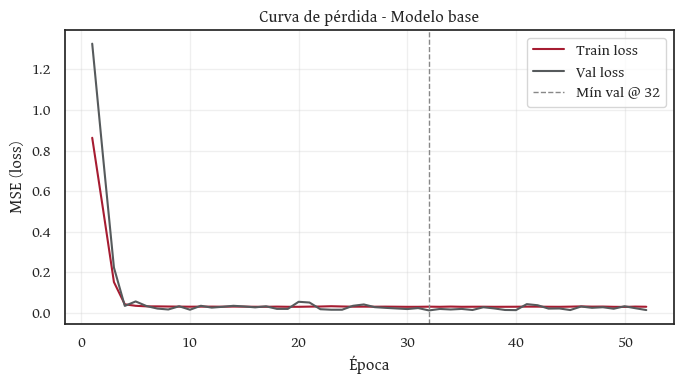

Figura guardada en: /Users/scuartasr/Documents/Maestría/Tesis/tfm_tuberc/modelos/outputs/output/b_08_ml/cnn_loss_base.png


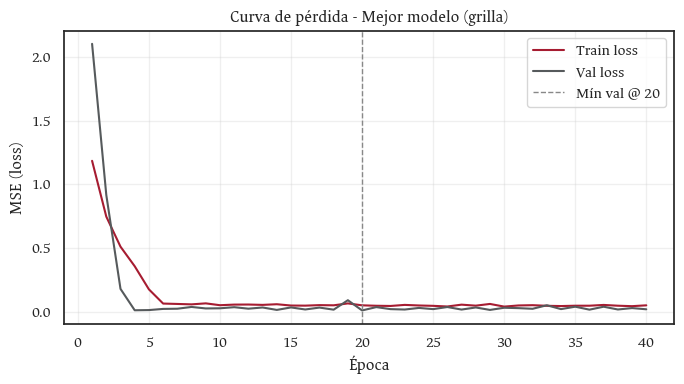

Figura guardada en: /Users/scuartasr/Documents/Maestría/Tesis/tfm_tuberc/modelos/outputs/output/b_08_ml/cnn_loss_best_grid.png


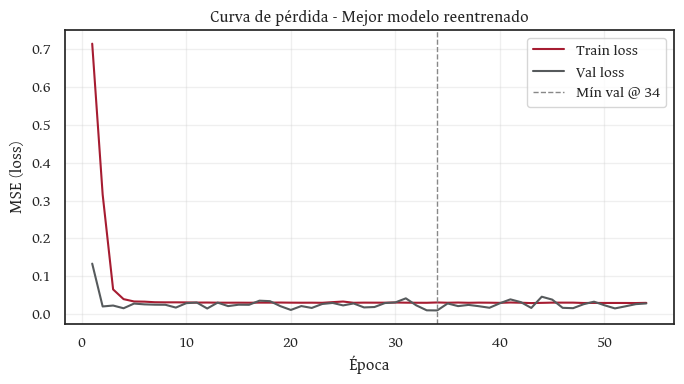

Figura guardada en: /Users/scuartasr/Documents/Maestría/Tesis/tfm_tuberc/modelos/outputs/output/b_08_ml/cnn_loss_best_retrain.png


In [23]:
# Curvas de pérdida (train/val) del modelo base y mejor modelo
import numpy as np
import matplotlib.pyplot as plt
from viz.style import get_palette

pal = get_palette(5)


def plot_loss_curves(history_obj, title, out_file):
    if hasattr(history_obj, 'history'):
        h = history_obj.history
    elif isinstance(history_obj, dict):
        h = history_obj
    else:
        print(f"No se puede graficar '{title}': formato de history no reconocido")
        return
    loss = h.get('loss', [])
    val_loss = h.get('val_loss', [])
    if len(loss) == 0 and len(val_loss) == 0:
        print(f"'{title}': no hay claves 'loss'/'val_loss' disponibles")
        return
    epochs = np.arange(1, max(len(loss), len(val_loss)) + 1)

    plt.figure(figsize=(7,4))
    if len(loss):
        plt.plot(epochs[:len(loss)], loss, label='Train loss', color=pal[1])
    if len(val_loss):
        plt.plot(epochs[:len(val_loss)], val_loss, label='Val loss', color=pal[4])
        try:
            best_ep = int(np.argmin(val_loss)) + 1
            plt.axvline(best_ep, color='#888888', ls='--', lw=1, label=f'Mín val @ {best_ep}')
        except Exception:
            pass
    plt.title(title)
    plt.xlabel('Época'); plt.ylabel('MSE (loss)')
    plt.grid(alpha=0.3); plt.legend()
    plt.tight_layout()
    save_path = os.path.join(OUT_DIR, out_file)
    plt.savefig(save_path, dpi=180)
    plt.show()
    print('Figura guardada en:', save_path)

# 1) Modelo base (si existe `hist`)
if 'hist' in globals():
    plot_loss_curves(hist, 'Curva de pérdida - Modelo base', 'cnn_loss_base.png')
else:
    print('Historial del modelo base no disponible (variable `hist`).')

# 2) Mejor modelo (historia de la mejor combinación durante grilla)
if 'best' in globals() and isinstance(best.get('history'), dict):
    plot_loss_curves(best['history'], 'Curva de pérdida - Mejor modelo (grilla)', 'cnn_loss_best_grid.png')
else:
    print('Historial del mejor modelo de grilla no disponible en `best["history"]`.')

# 3) Mejor modelo reentrenado (si se volvió a entrenar guardando `hist_best`)
if 'hist_best' in globals():
    plot_loss_curves(hist_best, 'Curva de pérdida - Mejor modelo reentrenado', 'cnn_loss_best_retrain.png')


/Users/scuartasr/Documents/Maestría/Tesis/tfm_tuberc/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
In the future `np.bool` will be defined as the corresponding NumPy scalar.
Exact explainer: 301it [05:27,  1.12s/it]                         


Importancias SHAP por paso guardadas en: /Users/scuartasr/Documents/Maestría/Tesis/tfm_tuberc/modelos/outputs/output/b_08_ml/shap_importance_by_time.csv


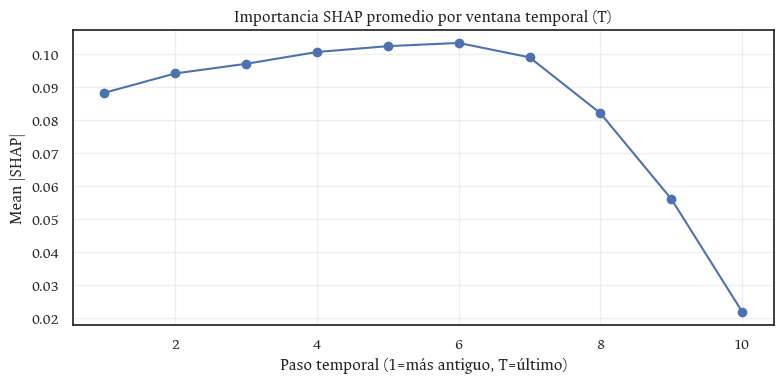

Figura guardada en: /Users/scuartasr/Documents/Maestría/Tesis/tfm_tuberc/modelos/outputs/output/b_08_ml/shap_mean_abs_by_time.png


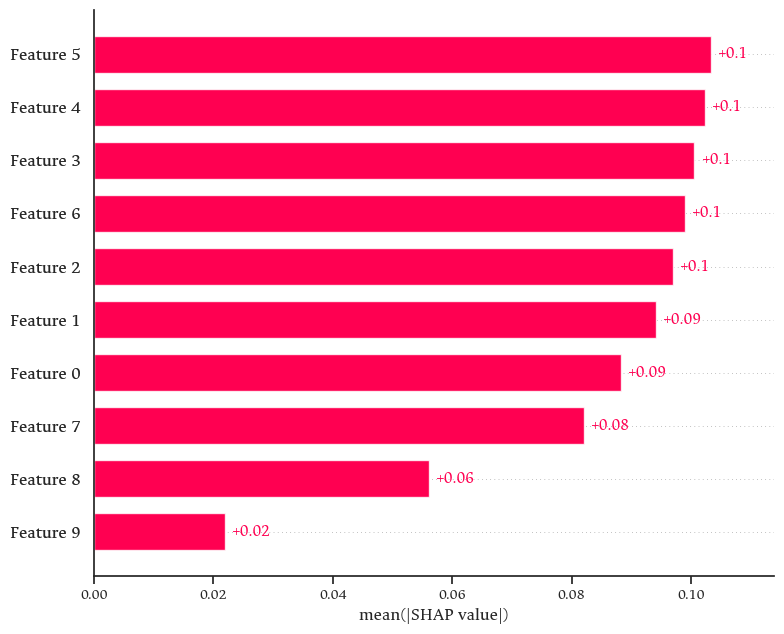

Figura guardada en: /Users/scuartasr/Documents/Maestría/Tesis/tfm_tuberc/modelos/outputs/output/b_08_ml/shap_summary_bar.png


In [ ]:
# Explicabilidad: valores SHAP sobre X_train (mejor modelo) usando Kernel Explainer
import numpy as np
import pandas as pd
import shap
import matplotlib.pyplot as plt

# Compatibilidad numpy/shap
if not hasattr(np, 'bool'):
    np.bool = np.bool_
if not hasattr(np, 'int'):
    np.int = int

# Requisitos previos
assert 'best_model' in globals(), 'No existe best_model. Ejecuta la celda de reentrenamiento del mejor modelo.'
assert 'X_train' in globals() and X_train.ndim == 3, 'Se espera X_train con forma (N,T,1)'

# Preparar subconjuntos
rng = np.random.default_rng(42)
idx_bg = rng.choice(X_train.shape[0], size=min(100, X_train.shape[0]), replace=False)
background = X_train[idx_bg]
idx_explain = rng.choice(X_train.shape[0], size=min(300, X_train.shape[0]), replace=False)
X_explain = X_train[idx_explain]

# Flatten temporal para un explainer tabular (Kernel)
# (N, T, 1) -> (N, T)
background_flat = background.squeeze(-1)
X_explain_flat = X_explain.squeeze(-1)

# Definir masker independiente por feature temporal
masker = shap.maskers.Independent(data=background_flat)

# Wrapper para rehacer dimensión (T,1) en predict
def _predict_flat(x_flat):
    x3 = np.array(x_flat, dtype='float32').reshape((-1, X_train.shape[1], 1))
    return best_model.predict(x3, verbose=0).reshape(-1)

explainer = shap.Explainer(_predict_flat, masker)
shap_values = explainer(X_explain_flat)

# Importancias promedio por paso temporal
mean_abs_by_t = np.abs(shap_values.values).mean(axis=0)  # (T,)

# Guardar CSV
time_steps = np.arange(1, X_train.shape[1]+1)
csv_path = os.path.join(OUT_DIR, 'shap_importance_by_time.csv')
pd.DataFrame({'time_step': time_steps, 'mean_abs_shap': mean_abs_by_t}).to_csv(csv_path, index=False)
print('Importancias SHAP por paso guardadas en:', csv_path)

# Gráfico línea
plt.figure(figsize=(8,4))
plt.plot(time_steps, mean_abs_by_t, marker='o')
plt.title('Importancia SHAP promedio por ventana temporal (T)')
plt.xlabel('Paso temporal (1=más antiguo, T=último)')
plt.ylabel('Mean |SHAP|')
plt.grid(alpha=0.3)
plot_path = os.path.join(OUT_DIR, 'shap_mean_abs_by_time.png')
plt.tight_layout(); plt.savefig(plot_path, dpi=180); plt.show()
print('Figura guardada en:', plot_path)

# Bar summary
shap.plots.bar(shap_values, show=False)
bar_path = os.path.join(OUT_DIR, 'shap_summary_bar.png')
plt.tight_layout(); plt.savefig(bar_path, dpi=180); plt.show()
print('Figura guardada en:', bar_path)


Mapa índice → etiqueta:
 feature_index feature_label         nota
             0          t-10  más antiguo
             1           t-9             
             2           t-8             
             3           t-7             
             4           t-6             
             5           t-5             
             6           t-4             
             7           t-3             
             8           t-2             
             9           t-1 más reciente


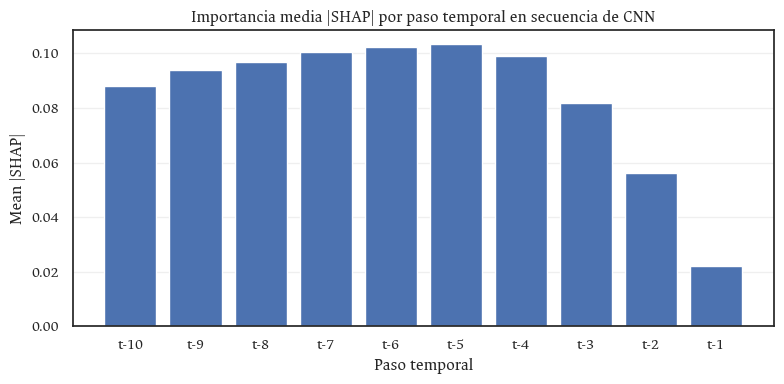

Figura guardada en: /Users/scuartasr/Documents/Maestría/Tesis/tfm_tuberc/modelos/outputs/output/b_08_ml/shap_summary_bar_named.png


In [25]:
# Etiquetas de features (ventana temporal) y gráfico con nombres
import numpy as np, pandas as pd, matplotlib.pyplot as plt

# Construir etiquetas: índice 0 = t-T (más antiguo), índice T-1 = t-1 (más reciente)
T_local = int(X_train.shape[1])
labels = [f't-{T_local - i}' for i in range(T_local)]
notes = ['más antiguo'] + ['']*(max(T_local-2,0)) + (['más reciente'] if T_local>1 else [])

mapping_df = pd.DataFrame({
    'feature_index': np.arange(T_local),
    'feature_label': labels,
    'nota': notes
})
print('Mapa índice → etiqueta:')
print(mapping_df.to_string(index=False))

# Importancias para etiquetas
try:
    imp = mean_abs_by_t  # de la celda SHAP anterior
except NameError:
    # cargar de CSV si no está en memoria
    _csv = os.path.join(OUT_DIR, 'shap_importance_by_time.csv')
    imp = pd.read_csv(_csv)['mean_abs_shap'].values

# Gráfico de barras con etiquetas correctas
plt.figure(figsize=(8,4))
plt.bar(labels, imp)
plt.title('Importancia media |SHAP| por paso temporal en secuencia de CNN')
plt.xlabel('Paso temporal'); plt.ylabel('Mean |SHAP|')
plt.xticks(rotation=0)
plt.grid(axis='y', alpha=0.3)
bar_named = os.path.join(OUT_DIR, 'shap_summary_bar_named.png')
plt.tight_layout(); plt.savefig(bar_named, dpi=180); plt.show()
print('Figura guardada en:', bar_named)


# Etiquetas APC (Edad–Período–Cohorte) para las features

Las features de nuestro modelo son T pasos temporales anteriores (lags) de la misma serie del grupo etario; por ello, su etiqueta natural es “lag temporal” (p.ej., t-10 … t-1). Sin embargo, en términos APC, cada contribución SHAP de una feature depende del trío específico de la muestra:

- Grupo etario (edad del objetivo)
- Período objetivo (año de la predicción)
- Cohorte asociada a la feature (aprox. año de nacimiento)

Para una muestra con edad `a` y período objetivo `p`, la feature en el lag `k` proviene del período `p_k = p - k`. Su cohorte aproximada puede definirse como `c_k = p_k - edad_media_del_grupo(a)` (usando la edad media del grupo de 5 años). Como estas etiquetas varían muestra a muestra, agregamos las |SHAP| por (edad × período de la feature) y por (edad × cohorte) para visualizar la importancia en coordenadas APC.

APC-SHAP exportado a: /Users/scuartasr/Documents/Maestría/Tesis/tfm_tuberc/modelos/outputs/output/b_08_ml/shap_attributions_apc.csv | filas: 3000


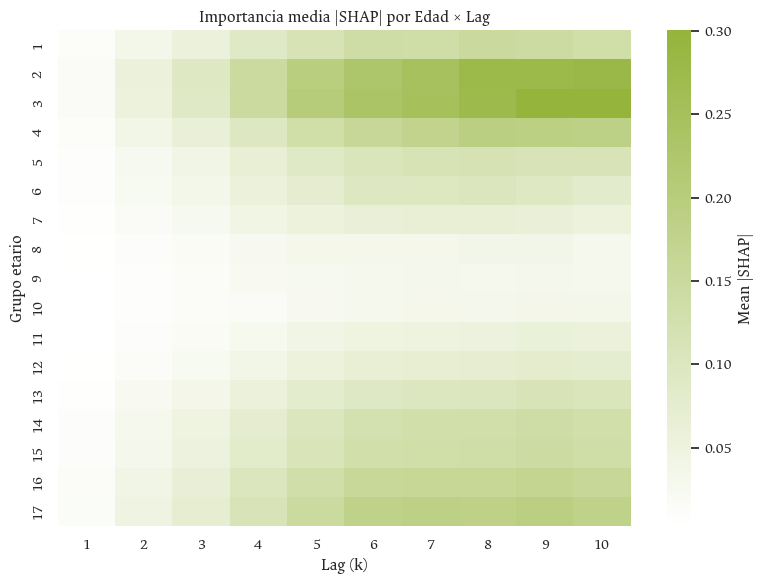

Figura guardada: /Users/scuartasr/Documents/Maestría/Tesis/tfm_tuberc/modelos/outputs/output/b_08_ml/shap_heatmap_age_vs_lag.png


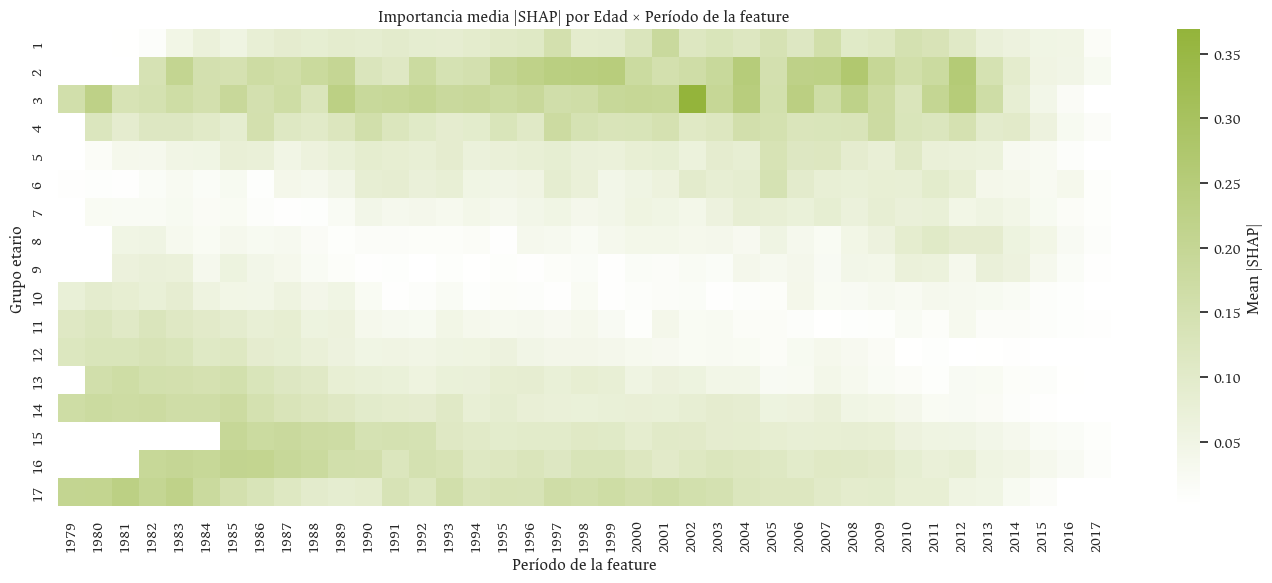

Figura guardada: /Users/scuartasr/Documents/Maestría/Tesis/tfm_tuberc/modelos/outputs/output/b_08_ml/shap_heatmap_age_vs_feature_period.png


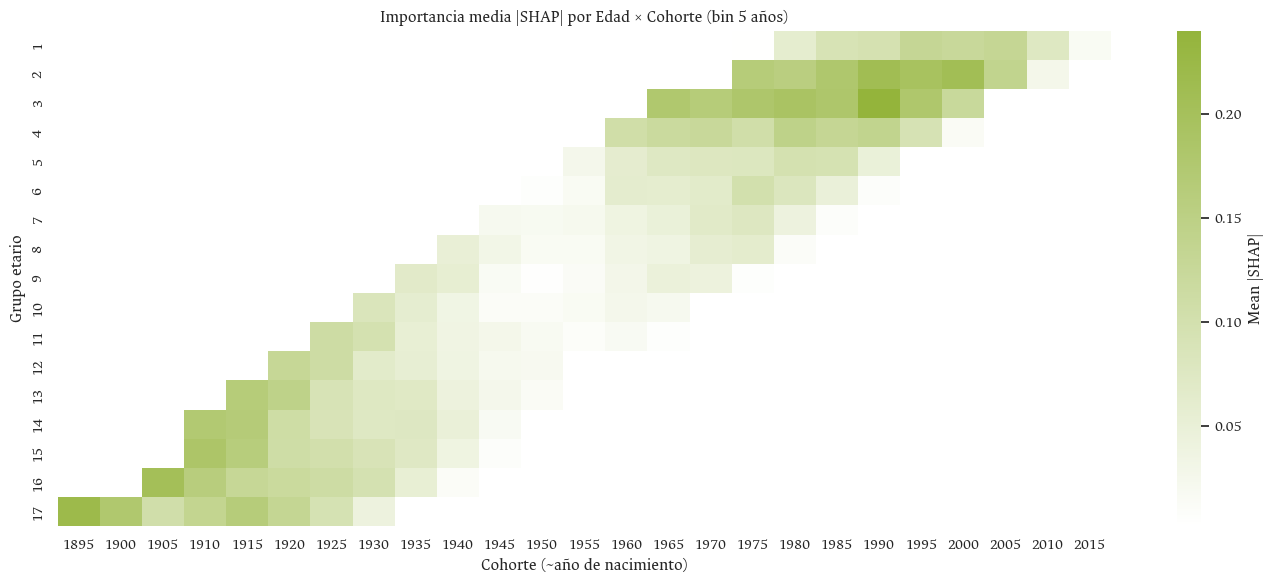

Figura guardada: /Users/scuartasr/Documents/Maestría/Tesis/tfm_tuberc/modelos/outputs/output/b_08_ml/shap_heatmap_age_vs_cohort.png


In [29]:
# APC-SHAP: construir etiquetas por muestra y agregar importancias
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os

from viz.style import get_sequential_cmap

# Requisitos: resultados SHAP kernel ya calculados y los índices de las muestras explicadas
assert 'shap_values' in globals(), 'No se encontraron valores SHAP. Ejecuta la celda SHAP primero.'
assert 'idx_explain' in globals(), 'No se encontró idx_explain. Ejecuta la celda SHAP primero.'
assert 'meta_age' in globals() and 'meta_year' in globals(), 'Se requieren meta_age/meta_year.'

T_local = int(X_train.shape[1])
S = len(idx_explain)
shap_arr = np.asarray(shap_values.values)  # (S, T)

# Helper: edad media (en años) del grupo etario (grupos de 5 años)
ages_arr = np.array(ages)
min_age_code = int(ages_arr.min())

def age_group_mid_years(a_code: int) -> int:
    if min_age_code == 0:
        return a_code * 5 + 2
    else:
        return (a_code - 1) * 5 + 2

rows = []
for j in range(S):
    gidx = int(idx_explain[j])
    age_g = int(meta_age[gidx])
    year_tgt = int(meta_year[gidx])
    for i in range(T_local):
        lag = T_local - i  # 10..1 si T=10
        period_feat = int(year_tgt - lag)
        cohort_year = int(period_feat - age_group_mid_years(age_g))
        val = float(abs(shap_arr[j, i]))
        rows.append({
            'age_group': age_g,
            'target_year': year_tgt,
            'lag': lag,
            'feature_period': period_feat,
            'cohort_year': cohort_year,
            'abs_shap': val
        })

apc_df = pd.DataFrame(rows)

# Guardar detalle en CSV
csv_path = os.path.join(OUT_DIR, 'shap_attributions_apc.csv')
apc_df.to_csv(csv_path, index=False)
print('APC-SHAP exportado a:', csv_path, '| filas:', len(apc_df))

# 1) Heatmap Edad × Lag (mean |SHAP|)
piv_age_lag = apc_df.pivot_table(index='age_group', columns='lag', values='abs_shap', aggfunc='mean')
plt.figure(figsize=(8, 6))
sns.heatmap(piv_age_lag.sort_index(), cmap=get_sequential_cmap(0), cbar_kws={'label': 'Mean |SHAP|'})
plt.title('Importancia media |SHAP| por Edad × Lag')
plt.xlabel('Lag (k)'); plt.ylabel('Grupo etario')
path1 = os.path.join(OUT_DIR, 'shap_heatmap_age_vs_lag.png')
plt.tight_layout(); plt.savefig(path1, dpi=180); plt.show()
print('Figura guardada:', path1)

# 2) Heatmap Edad × Período de la feature (p - k)
piv_age_period = apc_df.pivot_table(index='age_group', columns='feature_period', values='abs_shap', aggfunc='mean')
plt.figure(figsize=(14, 6))
sns.heatmap(piv_age_period.sort_index(), cmap=get_sequential_cmap(0), cbar_kws={'label': 'Mean |SHAP|'})
plt.title('Importancia media |SHAP| por Edad × Período de la feature')
plt.xlabel('Período de la feature'); plt.ylabel('Grupo etario')
path2 = os.path.join(OUT_DIR, 'shap_heatmap_age_vs_feature_period.png')
plt.tight_layout(); plt.savefig(path2, dpi=180); plt.show()
print('Figura guardada:', path2)

# 3) Heatmap Edad × Cohorte (aprox.)
# Opcional: agrupar cohortes en bins de 5 años para suavizar
apc_df['cohort_bin'] = (apc_df['cohort_year'] // 5) * 5
piv_age_cohort = apc_df.pivot_table(index='age_group', columns='cohort_bin', values='abs_shap', aggfunc='mean')
plt.figure(figsize=(14, 6))
sns.heatmap(piv_age_cohort.sort_index(), cmap=get_sequential_cmap(0), cbar_kws={'label': 'Mean |SHAP|'})
plt.title('Importancia media |SHAP| por Edad × Cohorte (bin 5 años)')
plt.xlabel('Cohorte (~año de nacimiento)'); plt.ylabel('Grupo etario')
path3 = os.path.join(OUT_DIR, 'shap_heatmap_age_vs_cohort.png')
plt.tight_layout(); plt.savefig(path3, dpi=180); plt.show()
print('Figura guardada:', path3)


# ¿Qué vectores conforman `X_train`?

Cada fila de `X_train` es una ventana temporal de longitud `T` con los `T` años inmediatamente anteriores al año objetivo para un grupo etario específico. Formalmente, para un grupo etario `a` y un año objetivo `y` (≤ 2018):

- Los años de la ventana son `y-T, y-T+1, ..., y-1`.
- Los valores son `((log(m[a, año]) - mu) / sigma)` para cada año de esa ventana.
- El objetivo `y_train` correspondiente es `((log(m[a, y]) - mu) / sigma)`.

A continuación se imprimen ejemplos concretos y se verifica que coincidan exactamente con `X_train`.

In [30]:
# X_train: inspección con ejemplos verificables
import numpy as np
import pandas as pd

assert 'X_train' in globals() and 'y_train' in globals()
assert 'meta_age' in globals() and 'meta_year' in globals()

T_local = int(T)

# Utilidad: reconstruir la ventana (años y valores) para el ejemplo i
def reconstruir_ventana(i):
    a = int(meta_age[i])
    y = int(meta_year[i])
    t_idx = int(np.where(years == y)[0][0])
    win_years = years[t_idx - T_local : t_idx].astype(int)
    x_log = mat_log.loc[a, win_years].values.astype(float)
    x_norm = ((x_log - mu) / sigma).astype(np.float32)
    y_log = float(mat_log.loc[a, y])
    y_norm = float((y_log - mu) / sigma)
    return a, y, win_years, x_norm, y_norm

# Elegimos algunos índices de muestra para mostrar
indices_demo = [0, 1, 2, len(X_train)//4, len(X_train)//2, -1]

filas = []
for i in indices_demo:
    i = int(i) % len(X_train)
    a, y, win_years, x_norm_rec, y_norm_rec = reconstruir_ventana(i)
    coincide = bool(np.allclose(x_norm_rec, X_train[i, :, 0], atol=1e-6))
    filas.append({
        'idx_muestra': i,
        'age': a,
        'target_year': y,
        'window_years': list(map(int, win_years)),
        'x_vector_norm': np.round(x_norm_rec, 6).tolist(),
        'y_norm': round(y_norm_rec, 6),
        'igual_a_X_train': coincide
    })

df_demo = pd.DataFrame(filas)
print('Ejemplos de filas de X_train (ventana y verificación):')
print(df_demo.to_string(index=False))


Ejemplos de filas de X_train (ventana y verificación):
 idx_muestra  age  target_year                                                 window_years                                                                                                                                                                                                        x_vector_norm    y_norm  igual_a_X_train
           0    1         1989 [1979, 1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988]  [0.23153500258922577, 0.14330999553203583, 0.1678989976644516, 0.09841900318861008, -0.11565300077199936, -0.2595129907131195, -0.2068299949169159, -0.37470099329948425, -0.4906260073184967, -0.5373290181159973] -0.663553             True
           1    1         1990 [1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989]  [0.14330999553203583, 0.1678989976644516, 0.09841900318861008, -0.11565300077199936, -0.2595129907131195, -0.2068299949169159, -0.37470099329948425, -0.4906260073184967, -0.537329018115997

# Entrada con canales APC explícitos + SHAP por canal

Vamos a ampliar la entrada de `(N, T, 1)` a `(N, T, C)` con canales que hagan explícitos los ejes APC:

- `logm_norm`: serie base (la original, normalizada) por paso temporal.
- `feature_period_norm`: año de la feature (p−k) normalizado por media/desv. de años de entrenamiento.
- `feature_cohort_norm`: cohorte de la feature (p−k − edad_media_grupo) normalizada.
- `age_mid_norm`: edad media del grupo (canal constante por tiempo dentro de la muestra).
- `target_period_norm`: período objetivo p (canal constante por tiempo dentro de la muestra).

Entrenaremos un modelo Conv1D con `input_shape=(T, C)` y luego mediremos SHAP agrupando las contribuciones por canal para comparar su importancia relativa.

In [31]:
# Construcción de `X_train_apc` (N,T,C) y entrenamiento
import numpy as np
import pandas as pd
from tensorflow.keras import layers, models, optimizers, callbacks

assert 'X_train' in globals() and 'y_train' in globals()

# Mapear edad media del grupo quinquenal
ages_arr = np.array(ages)
min_age_code = int(ages_arr.min())

def age_group_mid_years(a_code: int) -> int:
    if min_age_code == 0:
        return a_code * 5 + 2
    else:
        return (a_code - 1) * 5 + 2

N = X_train.shape[0]
T_local = X_train.shape[1]

# Reconstruir para todas las muestras: edad, año objetivo, años de la ventana
meta_age_arr = np.array(meta_age, dtype=int)
meta_year_arr = np.array(meta_year, dtype=int)

# Precomputar estadísticas para normalizar canales APC
train_years = years[:idx_cut+1].astype(int)
mean_year, std_year = float(np.mean(train_years)), float(np.std(train_years) + 1e-8)

age_mid_all = np.array([age_group_mid_years(a) for a in meta_age_arr], dtype=float)
mean_age_mid, std_age_mid = float(np.mean(age_mid_all)), float(np.std(age_mid_all) + 1e-8)

# Para cohorte (p - edad): usar todos los objetivos de train
cohort_target_all = meta_year_arr.astype(float) - age_mid_all
mean_cohort, std_cohort = float(np.mean(cohort_target_all)), float(np.std(cohort_target_all) + 1e-8)

# Construir canales
logm_norm = X_train[:, :, 0]  # ya normalizado

# feature_period por paso temporal (p - lag)
feature_period = np.empty((N, T_local), dtype=float)
for i in range(N):
    y = meta_year_arr[i]
    feature_period[i, :] = np.arange(y - T_local, y, dtype=int)
feature_period_norm = (feature_period - mean_year) / std_year

# feature_cohort = (p - lag) - edad_media_grupo(a)
age_mid_rep = np.repeat(age_mid_all[:, None], T_local, axis=1)
feature_cohort = feature_period - age_mid_rep
feature_cohort_norm = (feature_cohort - mean_cohort) / std_cohort

# age_mid_norm (constante por tiempo)
age_mid_norm = (age_mid_rep - mean_age_mid) / std_age_mid

# target_period_norm (constante por tiempo)
target_period_norm = (np.repeat(meta_year_arr[:, None], T_local, axis=1) - mean_year) / std_year

# Apilar canales: C=5
X_train_apc = np.stack([
    logm_norm.astype(np.float32),
    feature_period_norm.astype(np.float32),
    feature_cohort_norm.astype(np.float32),
    age_mid_norm.astype(np.float32),
    target_period_norm.astype(np.float32)
], axis=2)

print('X_train_apc shape:', X_train_apc.shape)

# Definir y entrenar modelo con entrada (T,C)
def build_cnn_apc(conv_layers=2, filters=32, kernel_size=3, dense_units=16, learning_rate=1e-3, C=5):
    m = models.Sequential()
    m.add(layers.Input(shape=(T_local, C)))
    for _ in range(conv_layers):
        m.add(layers.Conv1D(filters=filters, kernel_size=kernel_size, activation='relu', padding='causal'))
    m.add(layers.GlobalAveragePooling1D())
    m.add(layers.Dense(dense_units, activation='relu'))
    m.add(layers.Dense(1))
    m.compile(optimizer=optimizers.Adam(learning_rate=learning_rate), loss='mse')
    return m

# Usar mejores hiperparámetros si existen
if 'best' in globals() and best.get('params'):
    bp = best['params']
    conv_layers = bp['conv_layers']; filters = bp['filters']; kernel_size = bp['kernel_size']
    dense_units = bp['dense_units']; lr = bp['learning_rate']; batch_size = bp['batch_size']; epochs = bp['epochs']
else:
    conv_layers, filters, kernel_size, dense_units = 2, 32, 3, 16
    lr, batch_size, epochs = 1e-3, 32, 120

model_apc = build_cnn_apc(conv_layers, filters, kernel_size, dense_units, lr, C=X_train_apc.shape[2])
es_apc = callbacks.EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
hist_apc = model_apc.fit(X_train_apc, y_train, validation_split=0.1, epochs=epochs, batch_size=batch_size, verbose=0, callbacks=[es_apc])
print('Entrenado modelo APC. Épocas:', len(hist_apc.history.get('loss', [])))


X_train_apc shape: (510, 10, 5)
Entrenado modelo APC. Épocas: 43


Permutation explainer: 201it [01:31,  1.95it/s]                         

Importancia SHAP por canal guardada en: /Users/scuartasr/Documents/Maestría/Tesis/tfm_tuberc/modelos/outputs/output/b_08_ml/shap_channel_importance_apc.csv


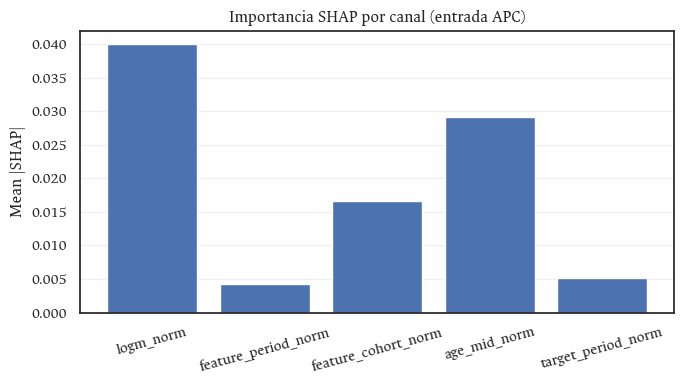

Figura guardada en: /Users/scuartasr/Documents/Maestría/Tesis/tfm_tuberc/modelos/outputs/output/b_08_ml/shap_channel_importance_apc.png


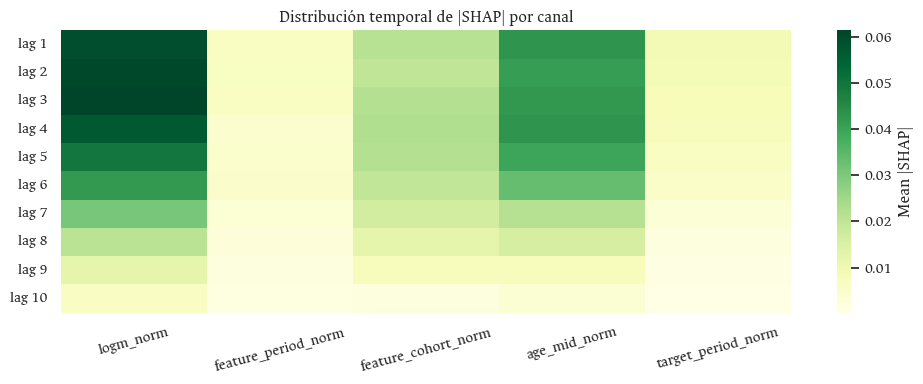

Figura guardada en: /Users/scuartasr/Documents/Maestría/Tesis/tfm_tuberc/modelos/outputs/output/b_08_ml/shap_time_by_channel_apc.png


In [32]:
# SHAP por canal (entrada APC)
import numpy as np
import pandas as pd
import shap
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Compat np/shap
if not hasattr(np, 'bool'): np.bool = np.bool_
if not hasattr(np, 'int'): np.int = int

assert 'model_apc' in globals() and 'X_train_apc' in globals()

# Submuestras para SHAP (ajusta si quieres mayor precisión)
rng = np.random.default_rng(123)
idx_bg_apc = rng.choice(X_train_apc.shape[0], size=min(60, X_train_apc.shape[0]), replace=False)
idx_explain_apc = rng.choice(X_train_apc.shape[0], size=min(200, X_train_apc.shape[0]), replace=False)

bg = X_train_apc[idx_bg_apc]
X_exp = X_train_apc[idx_explain_apc]

# Flatten (N, T, C) -> (N, T*C)
bg_flat = bg.reshape(bg.shape[0], -1)
X_exp_flat = X_exp.reshape(X_exp.shape[0], -1)

# Wrapper de predicción
def _predict_flat_apc(x_flat):
    x = np.array(x_flat, dtype='float32').reshape((-1, X_train_apc.shape[1], X_train_apc.shape[2]))
    return model_apc.predict(x, verbose=0).reshape(-1)

masker = shap.maskers.Independent(data=bg_flat)
expl_apc = shap.Explainer(_predict_flat_apc, masker)
sv_apc = expl_apc(X_exp_flat)

# Agregar |SHAP| por canal
T_local = X_train_apc.shape[1]
C = X_train_apc.shape[2]
vals = np.abs(sv_apc.values)  # (S, T*C)
vals = vals.reshape(vals.shape[0], T_local, C)
mean_abs_by_channel = vals.mean(axis=(0, 1))  # (C,)

channel_names = ['logm_norm', 'feature_period_norm', 'feature_cohort_norm', 'age_mid_norm', 'target_period_norm']

# Guardar CSV
csv_path = os.path.join(OUT_DIR, 'shap_channel_importance_apc.csv')
pd.DataFrame({'channel': channel_names[:C], 'mean_abs_shap': mean_abs_by_channel[:C]}).to_csv(csv_path, index=False)
print('Importancia SHAP por canal guardada en:', csv_path)

# Barra por canal
plt.figure(figsize=(7,4))
plt.bar(channel_names[:C], mean_abs_by_channel[:C])
plt.ylabel('Mean |SHAP|'); plt.title('Importancia SHAP por canal (entrada APC)')
plt.xticks(rotation=15); plt.grid(axis='y', alpha=0.3)
bar_path = os.path.join(OUT_DIR, 'shap_channel_importance_apc.png')
plt.tight_layout(); plt.savefig(bar_path, dpi=180); plt.show()
print('Figura guardada en:', bar_path)

# Heatmap tiempo × canal
plt.figure(figsize=(10,4))
heat = vals.mean(axis=0)  # (T, C)
sns.heatmap(heat, annot=False, cmap='YlGn', cbar_kws={'label': 'Mean |SHAP|'})
plt.yticks(np.arange(T_local)+0.5, [f'lag {k}' for k in range(1, T_local+1)], rotation=0)
plt.xticks(np.arange(C)+0.5, channel_names[:C], rotation=15)
plt.title('Distribución temporal de |SHAP| por canal')
hm_path = os.path.join(OUT_DIR, 'shap_time_by_channel_apc.png')
plt.tight_layout(); plt.savefig(hm_path, dpi=180); plt.show()
print('Figura guardada en:', hm_path)


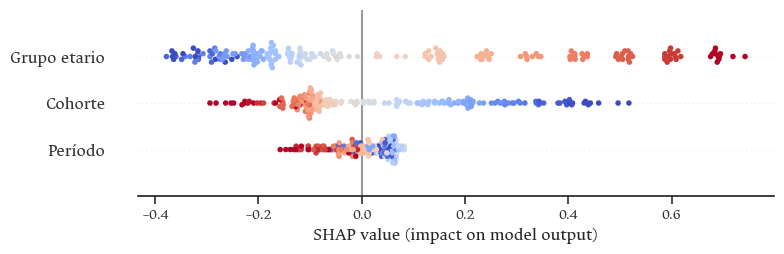

Figura guardada en: /Users/scuartasr/Documents/Maestría/Tesis/tfm_tuberc/modelos/outputs/output/b_08_ml/shap_beeswarm_apc_axes.png


In [34]:
# Beeswarm SHAP agregado por ejes APC (Edad, Cohorte, Período)
import numpy as np
import shap
import matplotlib.pyplot as plt
import os

# Requiere: sv_apc (SHAP sobre (T*C) flatten) y X_exp (submuestra explicada)
assert 'sv_apc' in globals() and 'X_exp' in globals() and 'X_train_apc' in globals()

S = sv_apc.values.shape[0]
T_local = X_train_apc.shape[1]
C = X_train_apc.shape[2]

# 1) Reagrupar SHAP por canal: sumamos sobre el eje temporal (aditividad de SHAP)
shap_tc = sv_apc.values.reshape(S, T_local, C)  # (S, T, C)
shap_ch = shap_tc.sum(axis=1)                    # (S, C)

# 2) Valores de features por canal (para color en beeswarm): promedio temporal
x_tc = X_exp.reshape(S, T_local, C)
feat_ch = x_tc.mean(axis=1)                      # (S, C)

# 3) Seleccionar solo ejes APC (Edad, Cohorte, Período)
# Orden de canales: [0]=logm_norm, [1]=feature_period_norm, [2]=feature_cohort_norm, [3]=age_mid_norm, [4]=target_period_norm
sel_idx = [3, 2, 4]
feature_names = ['Grupo etario', 'Cohorte', 'Período']

vals = shap_ch[:, sel_idx]
data = feat_ch[:, sel_idx]

# 4) Construir Explanation condensada por canal y graficar beeswarm (sin colorbar para evitar bug mpl)
expl_apc_axes = shap.Explanation(
    values=vals,
    base_values=sv_apc.base_values,
    data=data,
    feature_names=feature_names
)

plt.figure(figsize=(9, 3.3))
shap.plots.beeswarm(expl_apc_axes, show=False, max_display=10, color=plt.get_cmap('coolwarm'), color_bar=False)
plt.xlabel('SHAP value (impact on model output)')
fig_path = os.path.join(OUT_DIR, 'shap_beeswarm_apc_axes.png')
plt.tight_layout(); plt.savefig(fig_path, dpi=180); plt.show()
print('Figura guardada en:', fig_path)


Predicciones APC | TRAIN: (510, 4) | VAL: (85, 4)
Métricas APC (TRAIN y VAL):
- Train | MSE: 1.7176e-10 | RMSE: 1.3106e-05 | MAE: 7.0628e-06 | MAPE: 18.35% | sMAPE: 15.51% | WAPE: 10.03% | RMSE_log: 0.2332
- Val   | MSE: 1.4301e-09 | RMSE: 3.7817e-05 | MAE: 2.1060e-05 | MAPE: 36.75% | sMAPE: 45.59% | WAPE: 49.48% | RMSE_log: 0.5537


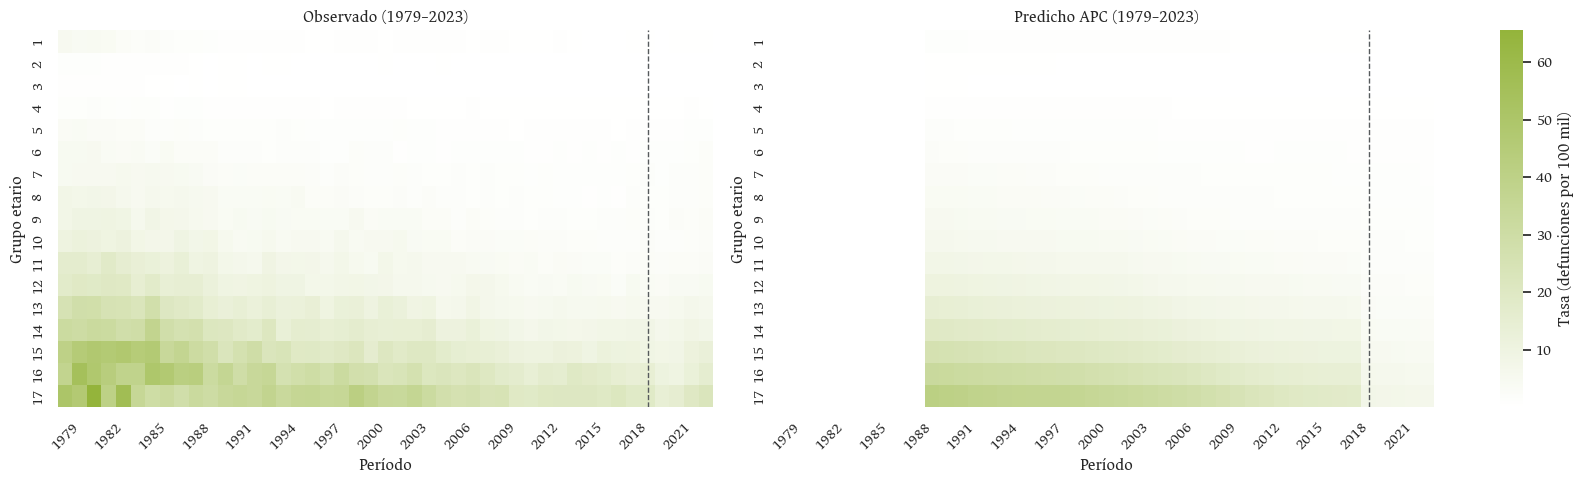

Figura guardada en: /Users/scuartasr/Documents/Maestría/Tesis/tfm_tuberc/modelos/outputs/output/b_08_ml/apc_matrices_obs_pred_1979_2023_100k.png


In [37]:
# Validación recursiva (1979–2023) con modelo APC: incluir TRAIN y VAL y comparar métricas
import numpy as np, pandas as pd, os
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns
from viz.style import get_palette, get_sequential_cmap

assert 'model_apc' in globals() and 'X_train_apc' in globals()

pal = get_palette(5)
color_obs, color_pred, color_vline = pal[0], pal[1], pal[4]

T_local = X_train_apc.shape[1]
C = X_train_apc.shape[2]

# --- Predicciones TRAIN (one-step) con modelo APC ---
yhat_train_scaled_apc = model_apc.predict(X_train_apc, verbose=0).reshape(-1)
yhat_train_log_apc = yhat_train_scaled_apc * sigma + mu
m_train_pred_apc = np.exp(yhat_train_log_apc)
ytrue_train_log_apc = np.array([mat_log.loc[a, y] for a, y in zip(meta_age, meta_year)])
m_train_obs_apc = np.exp(ytrue_train_log_apc)
train_df_apc = pd.DataFrame({'age': meta_age, 'year': meta_year, 'm_obs': m_train_obs_apc, 'm_pred': m_train_pred_apc})

# --- Predicción recursiva VALIDACIÓN (2019–2023) usando el modelo APC ---
val_years = years[idx_cut+1:]
Xv_meta_age_apc, Xv_meta_year_apc, yhat_val_log_apc = [], [], []

# Estadísticos de normalización consistentes con TRAIN
mean_year = float(np.mean(years[:idx_cut+1])); std_year = float(np.std(years[:idx_cut+1]) + 1e-8)
ages_arr = np.array(ages)
min_age_code = int(ages_arr.min())
ages_mid_all = np.array([ (a*5 + 2) if min_age_code==0 else ((a-1)*5 + 2) for a in ages ], dtype=float)
mean_age_mid = float(np.mean(ages_mid_all)); std_age_mid = float(np.std(ages_mid_all) + 1e-8)

for age in ages:
    s_log = mat_log.loc[age].values.copy()
    context_log = s_log[idx_cut+1-T_local:idx_cut+1].copy()
    age_mid = ( (age*5 + 2) if min_age_code==0 else ((age-1)*5 + 2) )
    # Para cohortes, usamos media/desv globales aproximadas del target de TRAIN
    cohort_train_all = (years[:idx_cut+1].astype(float) - age_mid)
    mean_cohort = float(np.mean(cohort_train_all)); std_cohort = float(np.std(cohort_train_all) + 1e-8)
    for yy in val_years:
        feature_period = np.arange(yy - T_local, yy, dtype=int)
        feature_cohort = feature_period - age_mid
        age_mid_vec = np.full(T_local, age_mid, dtype=float)
        target_period_vec = np.full(T_local, yy, dtype=int)
        # normalizaciones
        logm_norm = ((context_log - mu)/sigma).astype('float32')
        feature_period_norm = ((feature_period - mean_year)/ std_year).astype('float32')
        feature_cohort_norm = ((feature_cohort - mean_cohort) / std_cohort).astype('float32')
        age_mid_norm = ((age_mid_vec - mean_age_mid) / std_age_mid).astype('float32')
        target_period_norm = ((target_period_vec - mean_year)/ std_year).astype('float32')
        xin = np.stack([logm_norm, feature_period_norm, feature_cohort_norm, age_mid_norm, target_period_norm], axis=1).reshape(1, T_local, C)
        y_scaled = float(model_apc.predict(xin, verbose=0).reshape(-1)[0])
        y_log = y_scaled * sigma + mu
        yhat_val_log_apc.append(y_log)
        Xv_meta_age_apc.append(int(age)); Xv_meta_year_apc.append(int(yy))
        context_log = np.concatenate([context_log[1:], [y_log]])

m_val_pred_apc = np.exp(np.array(yhat_val_log_apc))
m_val_obs_apc = np.array([mat.loc[a, y] for a, y in zip(Xv_meta_age_apc, Xv_meta_year_apc)])
val_df_apc = pd.DataFrame({'age': Xv_meta_age_apc, 'year': Xv_meta_year_apc, 'm_obs': m_val_obs_apc, 'm_pred': m_val_pred_apc})
print('Predicciones APC | TRAIN:', train_df_apc.shape, '| VAL:', val_df_apc.shape)

# --- Métricas ---
EPS_LOCAL = 1e-12

def mape(y_true, y_pred, eps=1e-12):
    return 100 * np.mean(np.abs(y_pred - y_true) / (np.abs(y_true) + eps))

# Train
MSE_train_apc = float(mean_squared_error(train_df_apc['m_obs'], train_df_apc['m_pred']))
RMSE_train_apc = float(np.sqrt(MSE_train_apc))
MAE_train_apc = float(mean_absolute_error(train_df_apc['m_obs'], train_df_apc['m_pred']))
MAPE_train_apc = float(mape(train_df_apc['m_obs'], train_df_apc['m_pred'], EPS_LOCAL))
sMAPE_train_apc = float(100 * np.mean(2*np.abs(train_df_apc['m_pred'] - train_df_apc['m_obs']) / (np.abs(train_df_apc['m_pred']) + np.abs(train_df_apc['m_obs']) + EPS_LOCAL)))
WAPE_train_apc = float(100 * (np.sum(np.abs(train_df_apc['m_pred'] - train_df_apc['m_obs'])) / (np.sum(np.abs(train_df_apc['m_obs'])) + EPS_LOCAL)))
RMSE_log_train_apc = float(np.sqrt(mean_squared_error(np.log(np.clip(train_df_apc['m_obs'].values, EPS_LOCAL, None)), yhat_train_log_apc)))

# Val
MSE_val_apc = float(mean_squared_error(val_df_apc['m_obs'], val_df_apc['m_pred']))
RMSE_val_apc = float(np.sqrt(MSE_val_apc))
MAE_val_apc = float(mean_absolute_error(val_df_apc['m_obs'], val_df_apc['m_pred']))
MAPE_val_apc = float(mape(val_df_apc['m_obs'], val_df_apc['m_pred'], EPS_LOCAL))
sMAPE_val_apc = float(100 * np.mean(2*np.abs(val_df_apc['m_pred'] - val_df_apc['m_obs']) / (np.abs(val_df_apc['m_pred']) + np.abs(val_df_apc['m_obs']) + EPS_LOCAL)))
WAPE_val_apc = float(100 * (np.sum(np.abs(val_df_apc['m_pred'] - val_df_apc['m_obs'])) / (np.sum(np.abs(val_df_apc['m_obs'])) + EPS_LOCAL)))
RMSE_log_val_apc = float(np.sqrt(mean_squared_error(np.log(np.clip(val_df_apc['m_obs'].values, EPS_LOCAL, None)), np.array(yhat_val_log_apc))))

print('Métricas APC (TRAIN y VAL):')
print(f"- Train | MSE: {MSE_train_apc:.4e} | RMSE: {RMSE_train_apc:.4e} | MAE: {MAE_train_apc:.4e} | MAPE: {MAPE_train_apc:.2f}% | sMAPE: {sMAPE_train_apc:.2f}% | WAPE: {WAPE_train_apc:.2f}% | RMSE_log: {RMSE_log_train_apc:.4f}")
print(f"- Val   | MSE: {MSE_val_apc:.4e} | RMSE: {RMSE_val_apc:.4e} | MAE: {MAE_val_apc:.4e} | MAPE: {MAPE_val_apc:.2f}% | sMAPE: {sMAPE_val_apc:.2f}% | WAPE: {WAPE_val_apc:.2f}% | RMSE_log: {RMSE_log_val_apc:.4f}")

# --- Matrices y heatmap completo (1979–2023) ---
mat_train_pred_apc = pd.pivot_table(train_df_apc, index='age', columns='year', values='m_pred').reindex(index=ages, columns=years, fill_value=np.nan)
mat_val_pred_apc = pd.pivot_table(val_df_apc, index='age', columns='year', values='m_pred').reindex(index=ages, columns=years, fill_value=np.nan)
mat_obs_100k = mat * 1e5
mat_train_pred_100k_apc = mat_train_pred_apc * 1e5
mat_val_pred_100k_apc = mat_val_pred_apc * 1e5

mat_pred_full_100k_apc = pd.DataFrame(np.nan, index=ages, columns=years, dtype=float)
train_periods_apc = train_df_apc['year'].unique().astype(int)
val_periods_apc = val_df_apc['year'].unique().astype(int)
mat_pred_full_100k_apc.loc[:, train_periods_apc] = mat_train_pred_100k_apc.loc[:, train_periods_apc].values.astype(float)
mat_pred_full_100k_apc.loc[:, val_periods_apc] = mat_val_pred_100k_apc.loc[:, val_periods_apc].values.astype(float)

vmin_b = float(min(mat_obs_100k.values.min(), mat_pred_full_100k_apc.values.min()))
vmax_b = float(max(mat_obs_100k.values.max(), mat_pred_full_100k_apc.values.max()))
cmap_seq = get_sequential_cmap(index=0)

fig = plt.figure(figsize=(16,5))
gs = fig.add_gridspec(1,3, width_ratios=[1,1,0.035])
ax0 = fig.add_subplot(gs[0,0]); ax1 = fig.add_subplot(gs[0,1], sharey=ax0); cax = fig.add_subplot(gs[0,2])
sns.heatmap(mat_obs_100k, ax=ax0, cmap=cmap_seq, vmin=vmin_b, vmax=vmax_b, cbar=False)
ax0.set_title('Observado (1979–2023)'); ax0.set_xlabel('Período'); ax0.set_ylabel('Grupo etario')
sns.heatmap(mat_pred_full_100k_apc, ax=ax1, cmap=cmap_seq, vmin=vmin_b, vmax=vmax_b, cbar=True, cbar_ax=cax)
ax1.set_title('Predicho APC (1979–2023)'); ax1.set_xlabel('Período'); ax1.set_ylabel('Grupo etario')

tick_years = np.arange(1979, 2022, 3)
period_list = list(years)
pos_ticks = [period_list.index(y)+0.5 for y in tick_years if y in period_list]
lab_ticks = [str(y) for y in tick_years if y in period_list]
for a in (ax0, ax1):
    a.set_xticks(pos_ticks); a.set_xticklabels(lab_ticks, rotation=45)
idx_2019 = np.where(years == 2019)[0]
if len(idx_2019):
    xline = idx_2019[0]+0.5
    ax0.axvline(xline, color=color_vline, ls='--', lw=1)
    ax1.axvline(xline, color=color_vline, ls='--', lw=1)

cax.set_ylabel('Tasa (defunciones por 100 mil)')
out_hm = os.path.join(OUT_DIR,'apc_matrices_obs_pred_1979_2023_100k.png')
plt.tight_layout(); plt.savefig(out_hm, dpi=180); plt.show()
print('Figura guardada en:', out_hm)
